In [ ]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import time

from collections import OrderedDict
import numpy as np
import pandas as pd
from PIL import Image

from torch.autograd import Function
from torch.nn.parameter import Parameter

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
device='cpu'

In [ ]:
SEED = 1234
BATCH_SIZE = 100
torch.manual_seed(SEED)

use_cuda = torch.cuda.is_available()
root = './data'
if not os.path.exists(root):
    os.mkdir(root)

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.FashionMNIST(root=root, train=True, transform=trans, download=True)
train_set, val_set = random_split(train_set, [50000, 10000], generator=torch.Generator().manual_seed(SEED))
test_set = dset.FashionMNIST(root=root, train=False, transform=trans, download=True)



train_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=BATCH_SIZE, shuffle=False)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=BATCH_SIZE, shuffle=False)

print('==>>> total training batch number: {}'.format(len(train_loader)))
print('==>>> total validating batch number: {}'.format(len(val_loader)))
print('==>>> total testing batch number: {}'.format(len(test_loader)))

==>>> total training batch number: 500
==>>> total validating batch number: 100
==>>> total testing batch number: 100


In [ ]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc
def train(model, loader, optimizer, criterion, epoch):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.to(device), target.to(device)
        # if use_cuda:
        #     x, target = x.cuda(), target.cuda()
        # x, target = Variable(x), Variable(target)
        predictions = model(x)#.squeeze(1)
        loss = criterion(predictions, target)
        acc = categorical_accuracy(predictions, target)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        # if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(train_loader):
        #     print('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(epoch, batch_idx + 1, loss))

    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)

def evaluate(model, loader, criterion, epoch):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    # validating
    correct_cnt = 0
    total_cnt = 0
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(loader):
            x, target = x.to(device), target.to(device)
            # if use_cuda:
            #     x, target = x.cuda(), target.cuda()
            # x, target = Variable(x), Variable(target)
            predictions = model(x)#.squeeze(1)
            loss = criterion(predictions, target)
            acc = categorical_accuracy(predictions, target)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            _, pred_label = torch.max(predictions.data, 1)
            total_cnt += x.data.size()[0]
            correct_cnt += (pred_label == target.data).sum()

            # if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(loader):
            #     print('==>>> epoch: {}, batch index: {}, val loss: {:.6f}, acc: {:.3f}'.format(epoch, batch_idx + 1, loss, correct_cnt * 1.0 / total_cnt))

    return epoch_loss / len(loader), epoch_acc / len(loader)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def regenerate_model_and_start_train(use_fal=False, le_net=False, n_epochs = 10, device='cpu'):
    best_valid_loss = float('inf')
    model_name = ""
    if use_fal:
        if le_net:
            model = FLeNet()
            model_name = "FLENET_fashionmnist_{0}_epochs_model.pt".format(n_epochs)
        else:
            model = FMLPNet()
            model_name = "FMLPET_fashionmnist_{0}_epochs_model.pt".format(n_epochs)
    else:
        if le_net:
            model = LeNet()
            model_name = "LENET_fashionmnist_{0}_epochs_model.pt".format(n_epochs)
        else:
            model = MLPNet()
            model_name = "MLPNET_fashionmnist_{0}_epochs_model.pt".format(n_epochs)

    # if use_cuda:
        # model = model.cuda()
    model = model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    print(f'The model has {count_parameters(model):,} trainable parameters')
    
    for epoch in range(n_epochs):
        start_time = time.time()

        train_loss, train_acc = train(model, train_loader, optimizer, criterion, epoch)
        valid_loss, valid_acc = evaluate(model, val_loader, criterion, epoch)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_name)

        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

    if use_fal:
        a, p, n = model.get_fal_hyperparameters()
        print(f'\t\t FAL hyperparameters:')
        print(f'\t\t\t A: {a}')
        print(f'\t\t\t P: {p}')
        print(f'\t\t\t N: {n}')
    test_loss, test_acc = evaluate(model, test_loader, criterion, epoch=-1)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

    return model

In [ ]:
regenerate_model_and_start_train(False, False)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 1.287 | Train Acc: 70.31%
	 Val. Loss: 1.151 |  Val. Acc: 74.62%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 1.120 | Train Acc: 75.94%
	 Val. Loss: 1.107 |  Val. Acc: 76.72%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 1.092 | Train Acc: 78.04%
	 Val. Loss: 1.090 |  Val. Acc: 78.22%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 1.078 | Train Acc: 80.14%
	 Val. Loss: 1.078 |  Val. Acc: 80.35%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 1.066 | Train Acc: 81.88%
	 Val. Loss: 1.069 |  Val. Acc: 81.83%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 1.058 | Train Acc: 82.97%
	 Val. Loss: 1.061 |  Val. Acc: 82.44%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 1.051 | Train Acc: 83.46%
	 Val. Loss: 1.057 |  Val. Acc: 82.68%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 1.046 | Train Acc: 83.69%
	 Val. Loss: 1.053 |  Val. Acc: 82.85%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 1.041 | Train Acc: 83.89%
	 Val. Loss: 1.050 |  Val. Acc: 83.11%
Epoch: 10 | Epoch T

In [ ]:
regenerate_model_and_start_train(True, False)

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.953 | Train Acc: 75.14%
	 Val. Loss: 0.645 |  Val. Acc: 81.35%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.571 | Train Acc: 82.52%
	 Val. Loss: 0.529 |  Val. Acc: 83.11%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.504 | Train Acc: 83.79%
	 Val. Loss: 0.492 |  Val. Acc: 83.84%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.474 | Train Acc: 84.35%
	 Val. Loss: 0.479 |  Val. Acc: 84.16%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.456 | Train Acc: 84.75%
	 Val. Loss: 0.467 |  Val. Acc: 84.43%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.443 | Train Acc: 85.08%
	 Val. Loss: 0.460 |  Val. Acc: 84.64%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.434 | Train Acc: 85.24%
	 Val. Loss: 0.453 |  Val. Acc: 84.69%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.426 | Train Acc: 85.44%
	 Val. Loss: 0.449 |  Val. Acc: 84.83%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.419 | Train Acc: 85.64%
	 Val. Loss: 0.449 |  Val. Acc: 84.71%
Epoch: 10 | Epoch T

In [ ]:
regenerate_model_and_start_train(False, False)
# def __init__(self):
#         super(MLPNet, self).__init__()
#         self.fc1 = nn.Linear(28 * 28, 16)
#         self.fc2 = nn.Linear(16, 16)
#         self.fc3 = nn.Linear(16, 10)

# def forward(self, x):
#     x = x.view(-1, 28 * 28)
#     x = F.tanh(self.fc1(x))
#     x = F.tanh(self.fc2(x))
#     x = self.fc3(x)
#     return x

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 0.928 | Train Acc: 68.96%
	 Val. Loss: 0.572 |  Val. Acc: 79.57%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.504 | Train Acc: 82.38%
	 Val. Loss: 0.466 |  Val. Acc: 82.94%
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.441 | Train Acc: 84.49%
	 Val. Loss: 0.433 |  Val. Acc: 83.98%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.413 | Train Acc: 85.45%
	 Val. Loss: 0.418 |  Val. Acc: 84.85%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.395 | Train Acc: 86.02%
	 Val. Loss: 0.410 |  Val. Acc: 85.12%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.382 | Train Acc: 86.49%
	 Val. Loss: 0.405 |  Val. Acc: 85.15%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.372 | Train Acc: 86.84%
	 Val. Loss: 0.400 |  Val. Acc: 85.36%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.363 | Train Acc: 87.11%
	 Val. Loss: 0.397 |  Val. Acc: 85.50%
Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 0.356 | Train Acc: 87.38%
	 Val. Loss: 0.396 |  Val. Acc: 85.53%
Epoch: 10 | Epoch T

In [ ]:
regenerate_model_and_start_train(True, False)
# def __init__(self):
#         super(FMLPNet, self).__init__()
#         self.fc1 = nn.Linear(28 * 28, 16)
#         self.fal = FAL(16)
#         self.fc3 = nn.Linear(16, 10)

# def forward(self, x):
#     x = x.view(-1, 28 * 28)
#     x = F.tanh(self.fc1(x))
#     x = self.fal(x)
#     x = self.fc3(x)
#     return x

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 0.913 | Train Acc: 70.96%
	 Val. Loss: 0.549 |  Val. Acc: 80.14%
Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 0.480 | Train Acc: 83.11%
	 Val. Loss: 0.463 |  Val. Acc: 83.38%
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.432 | Train Acc: 84.56%
	 Val. Loss: 0.437 |  Val. Acc: 84.28%
Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 0.408 | Train Acc: 85.61%
	 Val. Loss: 0.429 |  Val. Acc: 84.74%
Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 0.393 | Train Acc: 86.04%
	 Val. Loss: 0.417 |  Val. Acc: 85.07%
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.381 | Train Acc: 86.35%
	 Val. Loss: 0.417 |  Val. Acc: 85.32%
Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 0.373 | Train Acc: 86.69%
	 Val. Loss: 0.406 |  Val. Acc: 85.68%
Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 0.363 | Train Acc: 87.00%
	 Val. Loss: 0.409 |  Val. Acc: 85.62%
Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 0.358 | Train Acc: 87.24%
	 Val. Loss: 0.398 |  Val. Acc: 86.13%
Epoch: 10 | Epoch T

In [ ]:
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        # self.fc1 = nn.Linear(28 * 28, 500)
        # self.fc2 = nn.Linear(500, 256)
        self.fc1 = nn.Linear(28 * 28, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 10)
        self.myrelu = MyReLU.apply

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        # F.relu
        x = self.myrelu(self.fc1(x))
        # x = self.myrelu(self.fc1(x))
        x = self.myrelu(self.fc2(x))
        # x = self.myrelu(self.fc2(x))
        # x = self.fc3(x)
        return x

    def name(self):
        return "MLP"


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 10)
        self.fc2 = nn.Linear(10, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        # x = self.fc2(x)
        return x

    def name(self):
        return "LeNet"

In [ ]:
regenerate_model_and_start_train(False, False)

The model has 13,002 trainable parameters
Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 1.096 | Train Acc: 64.48%
	 Val. Loss: 0.544 |  Val. Acc: 80.38%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.490 | Train Acc: 82.63%
	 Val. Loss: 0.479 |  Val. Acc: 83.07%


TypeError: ignored

In [ ]:
regenerate_model_and_start_train(True, False)

The model has 12,794 trainable parameters


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 0.891 | Train Acc: 71.32%
	 Val. Loss: 0.527 |  Val. Acc: 80.98%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.480 | Train Acc: 82.95%
	 Val. Loss: 0.465 |  Val. Acc: 83.13%
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.437 | Train Acc: 84.38%
	 Val. Loss: 0.447 |  Val. Acc: 83.99%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.411 | Train Acc: 85.27%
	 Val. Loss: 0.425 |  Val. Acc: 84.64%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.396 | Train Acc: 85.93%
	 Val. Loss: 0.420 |  Val. Acc: 84.89%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.384 | Train Acc: 86.37%
	 Val. Loss: 0.412 |  Val. Acc: 85.13%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.374 | Train Acc: 86.73%
	 Val. Loss: 0.412 |  Val. Acc: 85.15%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.366 | Train Acc: 86.96%
	 Val. Loss: 0.408 |  Val. Acc: 85.53%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.360 | Train Acc: 87.24%
	 Val. Loss: 0.404 |  Val. Acc: 85.96%
Epoch: 10 | Epoch T

In [ ]:
class FMLPNet(nn.Module):
    def __init__(self):
        super(FMLPNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 16)
        self.fal = FAL(16)
        self.fc3 = nn.Linear(16, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.tanh(self.fc1(x))
        # x = self.fc1(x)
        # x = F.relu(self.fc2(x))
        x = self.fal(x)
        x = self.fc3(x)
        return x
    
    def get_fal_hyperparameters(self):
        return self.fal.get_hyperparameters()

    def name(self):
        return "FMLP"
class FLeNet(nn.Module):
    def __init__(self):
        super(FLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 10)
        self.fal = FAL(10)
        # self.fc2 = nn.Linear(8, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fal(x)
        # x = self.fc2(x)
        return x

    def get_fal_hyperparameters(self):
        return self.fal.get_hyperparameters()

    def name(self):
        return "FLeNet"

In [ ]:
regenerate_model_and_start_train(False, False)

Epoch: 01 | Epoch Time: 0m 12s
	Train Loss: 0.777 | Train Acc: 72.28%
	 Val. Loss: 0.554 |  Val. Acc: 80.05%
Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 0.504 | Train Acc: 81.87%
	 Val. Loss: 0.495 |  Val. Acc: 82.20%
Epoch: 03 | Epoch Time: 0m 12s
	Train Loss: 0.467 | Train Acc: 83.41%
	 Val. Loss: 0.471 |  Val. Acc: 82.86%
Epoch: 04 | Epoch Time: 0m 13s
	Train Loss: 0.447 | Train Acc: 84.22%
	 Val. Loss: 0.458 |  Val. Acc: 83.47%
Epoch: 05 | Epoch Time: 0m 13s
	Train Loss: 0.435 | Train Acc: 84.62%
	 Val. Loss: 0.448 |  Val. Acc: 83.86%
Epoch: 06 | Epoch Time: 0m 12s
	Train Loss: 0.426 | Train Acc: 84.96%
	 Val. Loss: 0.443 |  Val. Acc: 84.09%
Epoch: 07 | Epoch Time: 0m 12s
	Train Loss: 0.420 | Train Acc: 85.23%
	 Val. Loss: 0.438 |  Val. Acc: 84.26%
Epoch: 08 | Epoch Time: 0m 13s
	Train Loss: 0.414 | Train Acc: 85.42%
	 Val. Loss: 0.435 |  Val. Acc: 84.34%
Epoch: 09 | Epoch Time: 0m 14s
	Train Loss: 0.410 | Train Acc: 85.58%
	 Val. Loss: 0.433 |  Val. Acc: 84.45%
Epoch: 10 | Epoch T

In [ ]:
regenerate_model_and_start_train(True, False)

Epoch: 01 | Epoch Time: 0m 13s
	Train Loss: 0.885 | Train Acc: 70.85%
	 Val. Loss: 0.549 |  Val. Acc: 80.92%
Epoch: 02 | Epoch Time: 0m 13s
	Train Loss: 0.495 | Train Acc: 82.75%
	 Val. Loss: 0.488 |  Val. Acc: 82.85%
Epoch: 03 | Epoch Time: 0m 13s
	Train Loss: 0.452 | Train Acc: 84.19%
	 Val. Loss: 0.469 |  Val. Acc: 83.82%
Epoch: 04 | Epoch Time: 0m 13s
	Train Loss: 0.431 | Train Acc: 84.93%
	 Val. Loss: 0.454 |  Val. Acc: 84.33%
Epoch: 05 | Epoch Time: 0m 14s
	Train Loss: 0.417 | Train Acc: 85.39%
	 Val. Loss: 0.444 |  Val. Acc: 84.68%
Epoch: 06 | Epoch Time: 0m 12s
	Train Loss: 0.407 | Train Acc: 85.71%
	 Val. Loss: 0.437 |  Val. Acc: 84.85%
Epoch: 07 | Epoch Time: 0m 12s
	Train Loss: 0.399 | Train Acc: 85.97%
	 Val. Loss: 0.432 |  Val. Acc: 85.17%
Epoch: 08 | Epoch Time: 0m 13s
	Train Loss: 0.392 | Train Acc: 86.19%
	 Val. Loss: 0.429 |  Val. Acc: 85.34%
Epoch: 09 | Epoch Time: 0m 13s
	Train Loss: 0.387 | Train Acc: 86.37%
	 Val. Loss: 0.426 |  Val. Acc: 85.52%
Epoch: 10 | Epoch T

In [ ]:
class FAL(nn.Module):
    __constants__ = ['n_features']
    n_features: int

    def __init__(self, n_features: int, bias: bool = True) -> None:
        super(FAL, self).__init__()
        self.tanh = nn.Tanh()
        self.n_features = n_features
        ta = torch.Tensor(1, n_features)
        ta.fill_(0.99)#0.2)#
        self.a = Parameter(ta)
        tp = torch.Tensor(1, n_features)
        tp.fill_(1.0)#2.5)#
        self.p = Parameter(tp)
        tn = torch.Tensor(1, n_features)
        tn.fill_(1.0)#2.2)
        self.n = Parameter(tn)

        self.a.requires_grad = True
        self.p.requires_grad = True
        self.n.requires_grad = True

        if bias:
            self.bias = Parameter(torch.Tensor(n_features).type(torch.DoubleTensor))
        else:
            self.register_parameter('bias', None)

        if self.bias is not None:
            self.bias.data.uniform_(-0.1, 0.1)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # input = input.clone()
        # max_values = torch.amax(input, 1)
        # max_values = max_values.reshape(input.shape[0], 1)
        # print("FAL max values:\n", max_values)

        # normalized_input = torch.div(input, max_values)
        # print('FAL normalized input:\n', normalized_input)

        # output = FRUFunction.apply(normalized_input, self.a, self.p, self.n)
        input = self.tanh(input)
        output = FRU(input, self.a, self.p, self.n)

        # print('FAL output after FRU forward:\n', output)

        # denormalized_output = torch.mul(output, max_values)
        denormalized_output = output


        if self.bias is not None:
            # print("FAL bias:\n", self.bias)
            denormalized_output += self.bias

        # print('FAL denormalized output:\n', denormalized_output)

        return denormalized_output
    
    def get_hyperparameters(self):
        return self.a, self.p, self.n

In [ ]:
regenerate_model_and_start_train(True, False)

Epoch: 01 | Epoch Time: 0m 12s
	Train Loss: 1.228 | Train Acc: 61.34%
	 Val. Loss: 0.652 |  Val. Acc: 77.59%
Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 0.568 | Train Acc: 80.75%
	 Val. Loss: 0.546 |  Val. Acc: 81.05%
		 FAL hyperparameters:
			 A: Parameter containing:
tensor([[0.6684, 0.8589, 0.7777, 0.9253, 0.5300, 0.9909, 0.6207, 0.7592]],
       requires_grad=True)
			 P: Parameter containing:
tensor([[1.2740, 2.9947, 3.2196, 2.8651, 2.2843, 0.9996, 2.7920, 2.9439]],
       requires_grad=True)
			 N: Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True)
Test Loss: 0.561 | Test Acc: 80.49%


In [ ]:
class FRUFunction(Function):
    @staticmethod
    def forward(ctx, s, a, p, n):
        # print("Forward")
        ams = a * s
        aps = a + s
        ass = a - s
        aps_minus_ams = aps - ams + 0.00001
        ass_plus_ams = ass + ams + 0.00001
        ams_plus_1 = ams + 1.00001
        ams_minus_1 = ams - 1.00001

        k_p = 1 / (aps_minus_ams) + (a - 1) / (ams_minus_1)
        k_n = 1 / (ass_plus_ams) + (1 - a) / (ams_plus_1)

        # k_p = 1 / (aps - ams) + (a - 1) / (ams - 1)
        # k_n = 1 / (ass + ams) + (1 - a) / (ams + 1)

        phi = 0.5 * torch.where(s > 0, p * k_p, n * k_n) * s

        ctx.save_for_backward(s, a, p, n, k_p, k_n, ams, aps, ass, aps_minus_ams, ass_plus_ams, ams_plus_1, ams_minus_1)
        # ctx.save_for_backward(s, a, p, n, k_p, k_n, ams, aps, ass)
        return phi

    @staticmethod
    def backward(ctx, grad_output):
        # print("Backward")
        grad_input = grad_output.clone()
        s, a, p, n, k_p, k_n, ams, aps, ass, aps_minus_ams, ass_plus_ams, ams_plus_1, ams_minus_1 = ctx.saved_tensors
        # s, a, p, n, k_p, k_n, ams, aps, ass = ctx.saved_tensors
        grad_s, grad_a, grad_p, grad_n = None, None, None, None
        aps_minus_ams_sqr = aps_minus_ams ** 2
        ass_plus_ams_sqr = ass_plus_ams ** 2
        ams_plus_1_sqr = ams_plus_1 ** 2
        ams_minus_1_sqr = ams_minus_1 ** 2

        if ctx.needs_input_grad[0]:
            # print("grad s should be updated")
            grad_s_k_p = a / (aps_minus_ams_sqr) - (a - 1) / (ams_minus_1_sqr)
            grad_s_k_n = a / (ass_plus_ams_sqr) - (a - 1) / (ams_plus_1_sqr)
            grad_s = grad_input * 0.5 * torch.where(s > 0, p * grad_s_k_p, n * grad_s_k_n)
        if ctx.needs_input_grad[1]:
            # print("grad A should be updated")
            grad_a_p = (s - 1) / (aps_minus_ams_sqr) + (s - 1) / (ams_minus_1_sqr)
            grad_a_n = (s + 1) / (ass_plus_ams_sqr) + (s + 1) / (ams_plus_1_sqr)
            grad_a = grad_input * 0.5 * s * torch.where(s > 0, p * grad_a_p, -n * grad_a_n)
        if ctx.needs_input_grad[2]:
            # print("grad P should be updated")
            where = torch.where(s > 0.0, 0.5 * s * k_p, 0. * s)
            grad_p = grad_input * where
        if ctx.needs_input_grad[3]:
            # print("grad N should be updated")
            where2 = torch.where(s > 0, 0. * s, 0.5 * s * k_n)
            # where2 = torch.where(s <= 0, 0.5 * s * k_n, 0. * s)
            grad_n = grad_output * where2
        #----------------------------
        # if ctx.needs_input_grad[0]:
        #     grad_s_k_p = a / ((aps - ams) ** 2) - (a - 1) / ((ams - 1) ** 2)
        #     grad_s_k_n = a / ((ass + ams) ** 2) - (a - 1) / ((ams + 1) ** 2)
        #     grad_s = grad_output * 0.5 * torch.where(s > 0, p * grad_s_k_p, n * grad_s_k_n)
        # if ctx.needs_input_grad[1]:
        #     grad_a_p = (s - 1) / ((aps - ams) ** 2) + (s - 1) / ((ams - 1) ** 2)
        #     grad_a_n = (s + 1) / ((ass + ams) ** 2) + (s + 1) / ((ams + 1) ** 2)
        #     grad_a = grad_output * 0.5 * s * torch.where(s > 0, p * grad_a_p, -n * grad_a_n)
        # if ctx.needs_input_grad[2]:
        #     where = torch.where(s > 0.0, 0.5 * s * k_p, 0. * s)
        #     grad_p = grad_output * where
        # if ctx.needs_input_grad[3]:
        #     grad_n = grad_output * torch.where(s > 0, 0. * s, 0.5 * s * k_n)
        #----------------------------

        return grad_s, grad_a, grad_p, grad_n
FRU = FRUFunction.apply

In [ ]:
class BruteReLU(Function):
    def __init__(self):
        super().__init__()  # init the base class

    @staticmethod
    def forward(ctx, inp):
        inp = inp.clone()
        ctx.save_for_backward(inp)
        return torch.where(inp > 0.0, inp, 0. * inp)

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        inp, = ctx.saved_tensors
        torch.where(inp > 0.0, 1.0, 0.)
        return torch.where(inp > 0.0, 1.0, 0.)

class MyReLU(Function):

    @staticmethod
    def forward(ctx, input):
        input = input.clone()
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input

In [ ]:
regenerate_model_and_start_train(False, False)

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 0.899 | Train Acc: 67.07%
	 Val. Loss: 0.578 |  Val. Acc: 78.98%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.513 | Train Acc: 81.35%
	 Val. Loss: 0.496 |  Val. Acc: 82.34%
Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 0.464 | Train Acc: 83.18%
	 Val. Loss: 0.459 |  Val. Acc: 83.66%
Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.436 | Train Acc: 84.24%
	 Val. Loss: 0.437 |  Val. Acc: 84.35%
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.416 | Train Acc: 84.90%
	 Val. Loss: 0.423 |  Val. Acc: 84.65%
Epoch: 06 | Epoch Time: 0m 9s
	Train Loss: 0.401 | Train Acc: 85.48%
	 Val. Loss: 0.414 |  Val. Acc: 85.02%
Epoch: 07 | Epoch Time: 0m 9s
	Train Loss: 0.388 | Train Acc: 85.95%
	 Val. Loss: 0.407 |  Val. Acc: 85.40%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.378 | Train Acc: 86.34%
	 Val. Loss: 0.401 |  Val. Acc: 85.60%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.369 | Train Acc: 86.60%
	 Val. Loss: 0.397 |  Val. Acc: 85.62%
Epoch: 10 | Epoch Time: 0

In [ ]:
regenerate_model_and_start_train(True, False)

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 1.055 | Train Acc: 66.86%
	 Val. Loss: 0.600 |  Val. Acc: 77.54%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.538 | Train Acc: 80.99%
	 Val. Loss: 0.518 |  Val. Acc: 81.65%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.483 | Train Acc: 83.06%
	 Val. Loss: 0.480 |  Val. Acc: 82.92%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.456 | Train Acc: 84.04%
	 Val. Loss: 0.463 |  Val. Acc: 83.49%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.440 | Train Acc: 84.66%
	 Val. Loss: 0.452 |  Val. Acc: 83.98%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.428 | Train Acc: 85.10%
	 Val. Loss: 0.445 |  Val. Acc: 84.36%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.419 | Train Acc: 85.45%
	 Val. Loss: 0.440 |  Val. Acc: 84.39%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.411 | Train Acc: 85.74%
	 Val. Loss: 0.437 |  Val. Acc: 84.40%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.405 | Train Acc: 85.88%
	 Val. Loss: 0.435 |  Val. Acc: 84.62%
Epoch: 10 | Epoch T

In [ ]:
n_features1=28
n_classes = 10
inp = torch.randn(n_features1 * n_features1).float()
# input.requires_grad=True
trgt = torch.randn(1).long()

# forward pass:
# - if any torch.nn function is called before the custom Function,
#   its backward pass is never executed.

myrel = MyReLU.apply
intermediate = inp.clone()                           # calling backward upon this works fine
# intermediate = torch.nn.ReLU()(input)        # uncomment this line and it won't work anymore
fal = FAL(n_features1)
fmlp = FMLPNet()
optmzr = optim.SGD(fmlp.parameters(), lr=0.01, momentum=0.9)
criter = nn.CrossEntropyLoss()

# pred = fal(intermediate)
# optmzr.zero_grad()
intermediate = intermediate.view(intermediate.shape[0], -1)
pred = fmlp(intermediate)
# pred = fal(intermediate)
lss = criter(pred, trgt)
# acc = categorical_accuracy(pred, trgt)
lss.backward()                                # this should always print "backward" to the command line
# optmzr.step()

In [ ]:
fmlp.get_fal_hyperparameters()

(Parameter containing:
 tensor([[0.9900, 0.9900, 0.9900, 0.9900, 0.9900, 0.9900, 0.9900, 0.9900]],
        requires_grad=True), Parameter containing:
 tensor([[1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True), Parameter containing:
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True))

In [ ]:
class testFMLPNet(nn.Module):
    def __init__(self, n_features, n_classes):
        # super(testFMLPNet, self).__init__()
        super().__init__()
        self.fc1 = nn.Linear(n_features, n_classes)
        self.fal = FAL(n_classes)
        self.fc3 = nn.Linear(n_classes, n_classes)
        

    def forward(self, x):
        # x = x.view(-1, self.n_features)
        x = F.relu(self.fc1(x))
        fal_x = self.fal(x)
        x = self.fc3(fal_x)
        return x
    
    def get_fal_hyperparameters(self):
        return self.fal.get_hyperparameters()

    def name(self):
        return "testFMLPNet"

In [ ]:
n_features1=28
n_classes = 10
inp = torch.randn(1, n_features1).float()
trgt = torch.randn(1).long()
tfmlp = testFMLPNet(n_features1, n_classes)
optmzr = optim.SGD(tfmlp.parameters(), lr=0.01, momentum=0.9)
criter = nn.CrossEntropyLoss()

# forward pass - if any torch.nn function is called before the custom Function,
#   its backward pass is never executed.

i = inp.clone()
fc1_ = nn.Linear(n_features1, n_classes)
fc3_ = nn.Linear(n_classes, n_classes)
fal_ = FAL(n_classes)
# pred = fal(i)
# optmzr.zero_grad()
# i = i.view(i.shape[0], -1)
i = i.view(-1, n_features1)
# i = F.relu(fc1_(i))
# i = fal_(i)
# i = fc3_(i)
# i = tfmlp(i)
lss = criter(i, trgt)
# lss = torch.nn.MSELoss()(pred,trgt)
# acc = categorical_accuracy(pred, trgt)
lss.backward()                                # this should always print "backward" to the command line
optmzr.step()

Forward
Backward
grad s should be updated
grad A should be updated
grad P should be updated
grad N should be updated
Backward finished


In [ ]:
regenerate_model_and_start_train(False, True)

Epoch: 01 | Epoch Time: 0m 47s
	Train Loss: 1.496 | Train Acc: 49.55%
	 Val. Loss: 1.140 |  Val. Acc: 59.78%
Epoch: 02 | Epoch Time: 0m 47s
	Train Loss: 1.017 | Train Acc: 62.73%
	 Val. Loss: 0.895 |  Val. Acc: 65.91%
Epoch: 03 | Epoch Time: 0m 47s
	Train Loss: 0.671 | Train Acc: 75.20%
	 Val. Loss: 0.623 |  Val. Acc: 76.94%
Epoch: 04 | Epoch Time: 0m 47s
	Train Loss: 0.577 | Train Acc: 78.59%
	 Val. Loss: 0.581 |  Val. Acc: 78.44%
Epoch: 05 | Epoch Time: 0m 47s
	Train Loss: 0.548 | Train Acc: 79.46%
	 Val. Loss: 0.559 |  Val. Acc: 79.12%
Epoch: 06 | Epoch Time: 0m 47s
	Train Loss: 0.528 | Train Acc: 80.01%
	 Val. Loss: 0.543 |  Val. Acc: 79.60%
Epoch: 07 | Epoch Time: 0m 47s
	Train Loss: 0.512 | Train Acc: 80.52%
	 Val. Loss: 0.530 |  Val. Acc: 80.03%
Epoch: 08 | Epoch Time: 0m 47s
	Train Loss: 0.499 | Train Acc: 80.93%
	 Val. Loss: 0.521 |  Val. Acc: 80.23%
Epoch: 09 | Epoch Time: 0m 47s
	Train Loss: 0.487 | Train Acc: 81.28%
	 Val. Loss: 0.514 |  Val. Acc: 80.39%
Epoch: 10 | Epoch T

In [ ]:
regenerate_model_and_start_train(True, True)

Epoch: 01 | Epoch Time: 0m 48s
	Train Loss: 1.706 | Train Acc: 49.62%
	 Val. Loss: 1.303 |  Val. Acc: 64.84%
Epoch: 02 | Epoch Time: 0m 48s
	Train Loss: 1.093 | Train Acc: 68.89%
	 Val. Loss: 0.950 |  Val. Acc: 73.32%
Epoch: 03 | Epoch Time: 0m 48s
	Train Loss: 0.854 | Train Acc: 74.23%
	 Val. Loss: 0.794 |  Val. Acc: 76.88%
Epoch: 04 | Epoch Time: 0m 48s
	Train Loss: 0.724 | Train Acc: 76.99%
	 Val. Loss: 0.697 |  Val. Acc: 79.06%
Epoch: 05 | Epoch Time: 0m 48s
	Train Loss: 0.645 | Train Acc: 78.35%
	 Val. Loss: 0.638 |  Val. Acc: 79.85%
Epoch: 06 | Epoch Time: 0m 47s
	Train Loss: 0.592 | Train Acc: 79.34%
	 Val. Loss: 0.597 |  Val. Acc: 80.26%
Epoch: 07 | Epoch Time: 0m 47s
	Train Loss: 0.553 | Train Acc: 80.17%
	 Val. Loss: 0.566 |  Val. Acc: 80.88%
Epoch: 08 | Epoch Time: 0m 47s
	Train Loss: 0.468 | Train Acc: 88.27%
	 Val. Loss: 0.465 |  Val. Acc: 87.78%
Epoch: 09 | Epoch Time: 0m 47s
	Train Loss: 0.407 | Train Acc: 89.60%
	 Val. Loss: 0.424 |  Val. Acc: 88.38%
Epoch: 10 | Epoch T

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def regenerate_model_and_count_params(use_fal=False, le_net=False, device='cpu'):
    if use_fal:
        if le_net:
            model = FLeNet()
        else:
            model = FMLPNet()
    else:
        if le_net:
            model = LeNet()
        else:
            model = MLPNet()

    # if use_cuda:
        # model = model.cuda()
    model = model.to(device)

    print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
regenerate_model_and_count_params(False, False)

The model has 13,002 trainable parameters


In [ ]:
regenerate_model_and_count_params(True, False)

The model has 12,794 trainable parameters


In [ ]:
regenerate_model_and_count_params(False, True)

The model has 33,690 trainable parameters


In [ ]:
regenerate_model_and_count_params(True, True)

The model has 33,620 trainable parameters


In [ ]:
regenerate_model_and_start_train(False, True)

The model has 33,690 trainable parameters
Epoch: 01 | Epoch Time: 0m 46s
	Train Loss: 1.447 | Train Acc: 48.75%
	 Val. Loss: 1.299 |  Val. Acc: 54.74%
Epoch: 02 | Epoch Time: 0m 46s
	Train Loss: 1.262 | Train Acc: 56.23%
	 Val. Loss: 1.292 |  Val. Acc: 55.65%
Epoch: 03 | Epoch Time: 0m 46s
	Train Loss: 1.096 | Train Acc: 63.56%
	 Val. Loss: 1.069 |  Val. Acc: 65.68%
Epoch: 04 | Epoch Time: 0m 46s
	Train Loss: 1.049 | Train Acc: 65.42%
	 Val. Loss: 1.050 |  Val. Acc: 66.19%
Epoch: 05 | Epoch Time: 0m 46s
	Train Loss: 0.961 | Train Acc: 66.17%
	 Val. Loss: 0.878 |  Val. Acc: 67.08%
Epoch: 06 | Epoch Time: 0m 46s
	Train Loss: 0.873 | Train Acc: 66.88%
	 Val. Loss: 0.866 |  Val. Acc: 67.35%
Epoch: 07 | Epoch Time: 0m 46s
	Train Loss: 0.861 | Train Acc: 67.11%
	 Val. Loss: 0.858 |  Val. Acc: 67.44%
Epoch: 08 | Epoch Time: 0m 47s
	Train Loss: 0.854 | Train Acc: 67.26%
	 Val. Loss: 0.853 |  Val. Acc: 67.60%
Epoch: 09 | Epoch Time: 0m 46s
	Train Loss: 0.847 | Train Acc: 67.40%
	 Val. Loss: 0.8

In [ ]:
regenerate_model_and_start_train(True, True)

The model has 33,620 trainable parameters
Epoch: 01 | Epoch Time: 0m 46s
	Train Loss: 1.705 | Train Acc: 50.19%
	 Val. Loss: 1.361 |  Val. Acc: 58.41%
Epoch: 02 | Epoch Time: 0m 46s
	Train Loss: 1.196 | Train Acc: 60.55%
	 Val. Loss: 1.080 |  Val. Acc: 62.26%
Epoch: 03 | Epoch Time: 0m 47s
	Train Loss: 1.003 | Train Acc: 63.77%
	 Val. Loss: 0.940 |  Val. Acc: 65.71%
Epoch: 04 | Epoch Time: 0m 46s
	Train Loss: 0.877 | Train Acc: 66.96%
	 Val. Loss: 0.843 |  Val. Acc: 67.70%
Epoch: 05 | Epoch Time: 0m 46s
	Train Loss: 0.800 | Train Acc: 68.33%
	 Val. Loss: 0.785 |  Val. Acc: 68.69%
Epoch: 06 | Epoch Time: 0m 47s
	Train Loss: 0.751 | Train Acc: 69.29%
	 Val. Loss: 0.747 |  Val. Acc: 69.26%
Epoch: 07 | Epoch Time: 0m 47s
	Train Loss: 0.714 | Train Acc: 69.97%
	 Val. Loss: 0.724 |  Val. Acc: 69.76%
Epoch: 08 | Epoch Time: 0m 46s
	Train Loss: 0.674 | Train Acc: 72.10%
	 Val. Loss: 0.649 |  Val. Acc: 76.99%
Epoch: 09 | Epoch Time: 0m 47s
	Train Loss: 0.573 | Train Acc: 79.20%
	 Val. Loss: 0.5

computing ROC and AUC

In [ ]:
import numpy as np
import argparse
from sklearn.metrics import *
from matplotlib import pyplot as plt
from itertools import cycle
%matplotlib inline

In [ ]:
def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)# top prediction (top_pred)
            actuals.extend(target.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

def test_class_probabilities_micro_macro_avergage(model, device, test_loader):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)# top prediction (top_pred)
            actuals.extend(prediction.eq(target.view_as(prediction)))
            # https://stackoverflow.com/a/61742667
            probabilities.extend(np.exp(output[np.indices(target.shape)[0], target]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

def compute_n_plot_roc(model, device, test_loader, which_class):
    actuals_, class_probabilities_ = test_class_probabilities(model, device, test_loader, which_class)

    fpr_, tpr_, _ = roc_curve(actuals_, class_probabilities_)
    roc_auc = auc(fpr_, tpr_)

    plt.figure()
    lw = 2
    plt.plot(fpr_, tpr_, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lime', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for digit=%d class' % which_class)
    plt.legend(loc="lower right")
    plt.show()

def compute_n_plot_roc_multiclass(model, device, test_loader, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for class_i in range(n_classes):
        actuals_i, class_probabilities_i = test_class_probabilities(model, device, test_loader, class_i)
        fpr[class_i], tpr[class_i], _ = roc_curve(actuals_i, class_probabilities_i)
        roc_auc[class_i] = auc(fpr[class_i], tpr[class_i])

    # Compute micro-average ROC curve and ROC area
    actuals_micro, class_probabilities_micro = test_class_probabilities_micro_macro_avergage(model, device, test_loader)
    fpr["micro"], tpr["micro"], _ = roc_curve(actuals_micro, class_probabilities_micro)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    lw = 2
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "blue", "black", "purple", "grey", "brown"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", color='grey', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC multiclass")
    plt.legend(loc="lower right")
    plt.show()

def compute_n_plot_roc_multiclass_for_2_models(model1, model2, device,
                                               test_loader, n_classes,
                                               model1_name, model2_name):
    fpr1 = dict()
    tpr1 = dict()
    fpr2 = dict()
    tpr2 = dict()
    roc_auc1 = dict()
    roc_auc2 = dict()
    for class_i in range(n_classes):
        actuals_i1, class_probabilities_i1 = test_class_probabilities(model1, device, test_loader, class_i)
        actuals_i2, class_probabilities_i2 = test_class_probabilities(model2, device, test_loader, class_i)
        fpr1[class_i], tpr1[class_i], _ = roc_curve(actuals_i1, class_probabilities_i1)
        fpr2[class_i], tpr2[class_i], _ = roc_curve(actuals_i2, class_probabilities_i2)
        roc_auc1[class_i] = auc(fpr1[class_i], tpr1[class_i])
        roc_auc2[class_i] = auc(fpr2[class_i], tpr2[class_i])

    # Compute micro-average ROC curve and ROC area
    actuals_micro1, class_probabilities_micro1 = test_class_probabilities_micro_macro_avergage(model1, device, test_loader)
    actuals_micro2, class_probabilities_micro2 = test_class_probabilities_micro_macro_avergage(model2, device, test_loader)
    fpr1["micro"], tpr1["micro"], _ = roc_curve(actuals_micro1, class_probabilities_micro1)
    fpr2["micro"], tpr2["micro"], _ = roc_curve(actuals_micro2, class_probabilities_micro2)
    roc_auc1["micro"] = auc(fpr1["micro"], tpr1["micro"])
    roc_auc2["micro"] = auc(fpr2["micro"], tpr2["micro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,10))
    lw = 2
    plt.plot(
        fpr1["micro"],
        tpr1["micro"],
        label="micro-average {1} (area = {0:0.2f})".format(roc_auc1["micro"], model1_name),
        color="black",
        linewidth=lw,
    )

    plt.plot(
        fpr2["micro"],
        tpr2["micro"],
        label="micro-average {1} (area = {0:0.2f})".format(roc_auc2["micro"], model2_name),
        color="grey",
        linewidth=lw,
    )

    plt.plot([0, 1], [0, 1], "k--", color='black', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC to multiclass")
    plt.legend(loc="lower right")
    plt.show()

def compute_n_plot_roc_multiclass_macro_for_2_models(model1, model2, device,
                                               test_loader, n_classes,
                                               model1_name, model2_name):
    fpr1 = dict()
    tpr1 = dict()
    fpr2 = dict()
    tpr2 = dict()
    roc_auc1 = dict()
    roc_auc2 = dict()
    for class_i in range(n_classes):
        actuals_i1, class_probabilities_i1 = test_class_probabilities(model1, device, test_loader, class_i)
        actuals_i2, class_probabilities_i2 = test_class_probabilities(model2, device, test_loader, class_i)
        fpr1[class_i], tpr1[class_i], _ = roc_curve(actuals_i1, class_probabilities_i1)
        fpr2[class_i], tpr2[class_i], _ = roc_curve(actuals_i2, class_probabilities_i2)
        roc_auc1[class_i] = auc(fpr1[class_i], tpr1[class_i])
        roc_auc2[class_i] = auc(fpr2[class_i], tpr2[class_i])

    # Compute micro-average ROC curve and ROC area
    actuals_micro1, class_probabilities_micro1 = test_class_probabilities_micro_macro_avergage(model1, device, test_loader)
    actuals_micro2, class_probabilities_micro2 = test_class_probabilities_micro_macro_avergage(model2, device, test_loader)
    # fpr1["micro"], tpr1["micro"], _ = roc_curve(actuals_micro1, class_probabilities_micro1)
    # fpr2["micro"], tpr2["micro"], _ = roc_curve(actuals_micro2, class_probabilities_micro2)
    # roc_auc1["micro"] = auc(fpr1["micro"], tpr1["micro"])
    # roc_auc2["micro"] = auc(fpr2["micro"], tpr2["micro"])

    # First aggregate all false positive rates
    all_fpr1 = np.unique(np.concatenate([fpr1[i] for i in range(n_classes)]))
    all_fpr2 = np.unique(np.concatenate([fpr2[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr1 = np.zeros_like(all_fpr1)
    mean_tpr2 = np.zeros_like(all_fpr2)
    for i in range(n_classes):
        mean_tpr1 += np.interp(all_fpr1, fpr1[i], tpr1[i])
        mean_tpr2 += np.interp(all_fpr2, fpr2[i], tpr2[i])

    # Finally average it and compute AUC
    mean_tpr1 /= n_classes
    mean_tpr2 /= n_classes

    # Compute micro-average ROC curve and ROC area
    actuals_micro1, class_probabilities_micro1 = test_class_probabilities_micro_macro_avergage(model1, device, test_loader)
    actuals_micro2, class_probabilities_micro2 = test_class_probabilities_micro_macro_avergage(model2, device, test_loader)
    fpr1["micro"], tpr1["micro"], _ = roc_curve(actuals_micro1, class_probabilities_micro1)
    fpr2["micro"], tpr2["micro"], _ = roc_curve(actuals_micro2, class_probabilities_micro2)
    roc_auc1["micro"] = auc(fpr1["micro"], tpr1["micro"])
    roc_auc2["micro"] = auc(fpr2["micro"], tpr2["micro"])

    # Plot all ROC curves
    

    fpr1["macro"] = all_fpr1
    fpr2["macro"] = all_fpr2
    tpr1["macro"] = mean_tpr1
    tpr2["macro"] = mean_tpr2
    roc_auc1["macro"] = auc(fpr1["macro"], tpr1["macro"])
    roc_auc2["macro"] = auc(fpr2["macro"], tpr2["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,10))
    lw = 2

    # plt.plot(
    #     fpr1["micro"],
    #     tpr1["micro"],
    #     label="micro-average {1} (area = {0:0.2f})".format(roc_auc1["micro"], model1_name),
    #     color="red",
    #     linewidth=lw,
    # )

    # plt.plot(
    #     fpr2["micro"],
    #     tpr2["micro"],
    #     "k--",
    #     label="micro-average {1} (area = {0:0.2f})".format(roc_auc2["micro"], model2_name),
    #     color="red",
    #     linewidth=lw,
    # )

    plt.plot(
        fpr1["macro"],
        tpr1["macro"],
        label="macro-average {1} (area = {0:0.2f})".format(roc_auc1["macro"], model1_name),
        color="black",
        linewidth=lw,
    )

    plt.plot(
        fpr2["macro"],
        tpr2["macro"],
        "k--",
        label="macro-average {1} (area = {0:0.2f})".format(roc_auc2["macro"], model2_name),
        color="black",
        linewidth=lw,
    )

    plt.plot([0, 1], [0, 1], color='grey', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC to multiclass")
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
MLP_model = regenerate_model_and_start_train(False, False)

The model has 13,002 trainable parameters
Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 1.255 | Train Acc: 61.53%
	 Val. Loss: 1.047 |  Val. Acc: 66.83%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.886 | Train Acc: 71.09%
	 Val. Loss: 0.767 |  Val. Acc: 73.57%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.717 | Train Acc: 75.08%
	 Val. Loss: 0.731 |  Val. Acc: 74.55%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.499 | Train Acc: 82.78%
	 Val. Loss: 0.443 |  Val. Acc: 84.32%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.413 | Train Acc: 85.51%
	 Val. Loss: 0.426 |  Val. Acc: 84.92%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.398 | Train Acc: 86.04%
	 Val. Loss: 0.415 |  Val. Acc: 85.28%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.388 | Train Acc: 86.36%
	 Val. Loss: 0.408 |  Val. Acc: 85.48%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.379 | Train Acc: 86.61%
	 Val. Loss: 0.403 |  Val. Acc: 85.70%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.373 | Train Acc: 86.79%
	 Val. Loss: 0.3

In [ ]:
FMLP_model = regenerate_model_and_start_train(True, False, n_epochs=25)

The model has 12,794 trainable parameters


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.907 | Train Acc: 71.86%
	 Val. Loss: 0.515 |  Val. Acc: 82.00%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.472 | Train Acc: 83.35%
	 Val. Loss: 0.460 |  Val. Acc: 83.85%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.428 | Train Acc: 84.83%
	 Val. Loss: 0.440 |  Val. Acc: 84.68%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.406 | Train Acc: 85.57%
	 Val. Loss: 0.431 |  Val. Acc: 84.91%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.389 | Train Acc: 86.19%
	 Val. Loss: 0.417 |  Val. Acc: 85.54%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.379 | Train Acc: 86.54%
	 Val. Loss: 0.409 |  Val. Acc: 85.72%
Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 0.368 | Train Acc: 86.91%
	 Val. Loss: 0.403 |  Val. Acc: 86.00%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.360 | Train Acc: 87.25%
	 Val. Loss: 0.398 |  Val. Acc: 86.21%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.354 | Train Acc: 87.39%
	 Val. Loss: 0.394 |  Val. Acc: 86.31%
Epoch: 10 | Epoch T

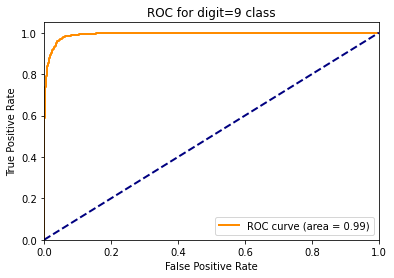

In [ ]:
compute_n_plot_roc(MLP_model, device, test_loader, 9)

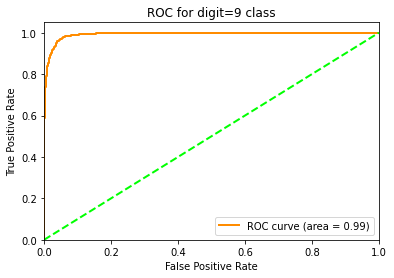

In [ ]:
compute_n_plot_roc(FMLP_model, device, test_loader, 9)

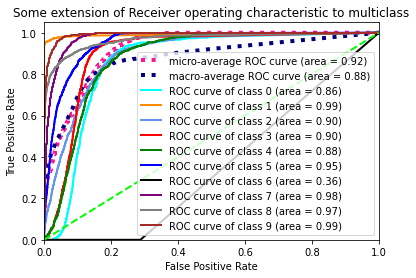

In [ ]:
compute_n_plot_roc_multiclass(MLP_model, device, test_loader, 10)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instea

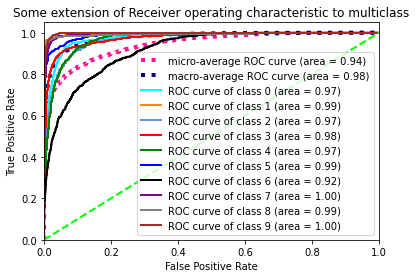

In [ ]:
compute_n_plot_roc_multiclass(FMLP_model, device, test_loader, 10)

In [ ]:
LeNet_model = regenerate_model_and_start_train(False, True, n_epochs=25)

The model has 33,690 trainable parameters
Epoch: 01 | Epoch Time: 0m 49s
	Train Loss: 1.005 | Train Acc: 63.80%
	 Val. Loss: 0.508 |  Val. Acc: 80.97%
Epoch: 02 | Epoch Time: 0m 45s
	Train Loss: 0.427 | Train Acc: 84.55%
	 Val. Loss: 0.419 |  Val. Acc: 84.87%
Epoch: 03 | Epoch Time: 0m 45s
	Train Loss: 0.370 | Train Acc: 86.69%
	 Val. Loss: 0.372 |  Val. Acc: 86.52%
Epoch: 04 | Epoch Time: 0m 46s
	Train Loss: 0.337 | Train Acc: 87.94%
	 Val. Loss: 0.347 |  Val. Acc: 87.31%
Epoch: 05 | Epoch Time: 0m 45s
	Train Loss: 0.313 | Train Acc: 88.82%
	 Val. Loss: 0.327 |  Val. Acc: 88.14%
Epoch: 06 | Epoch Time: 0m 45s
	Train Loss: 0.295 | Train Acc: 89.47%
	 Val. Loss: 0.314 |  Val. Acc: 88.65%
Epoch: 07 | Epoch Time: 0m 45s
	Train Loss: 0.280 | Train Acc: 90.00%
	 Val. Loss: 0.303 |  Val. Acc: 89.14%
Epoch: 08 | Epoch Time: 0m 45s
	Train Loss: 0.267 | Train Acc: 90.41%
	 Val. Loss: 0.295 |  Val. Acc: 89.38%
Epoch: 09 | Epoch Time: 0m 45s
	Train Loss: 0.256 | Train Acc: 90.84%
	 Val. Loss: 0.2

In [ ]:
FLeNet_model = regenerate_model_and_start_train(True, True, n_epochs=25)

The model has 33,620 trainable parameters
Epoch: 01 | Epoch Time: 0m 45s
	Train Loss: 1.517 | Train Acc: 61.52%
	 Val. Loss: 1.065 |  Val. Acc: 74.14%
Epoch: 02 | Epoch Time: 0m 45s
	Train Loss: 0.896 | Train Acc: 77.89%
	 Val. Loss: 0.794 |  Val. Acc: 79.20%
Epoch: 03 | Epoch Time: 0m 46s
	Train Loss: 0.703 | Train Acc: 81.77%
	 Val. Loss: 0.654 |  Val. Acc: 82.90%
Epoch: 04 | Epoch Time: 0m 46s
	Train Loss: 0.577 | Train Acc: 85.05%
	 Val. Loss: 0.546 |  Val. Acc: 85.68%
Epoch: 05 | Epoch Time: 0m 45s
	Train Loss: 0.500 | Train Acc: 86.81%
	 Val. Loss: 0.494 |  Val. Acc: 86.70%
Epoch: 06 | Epoch Time: 0m 45s
	Train Loss: 0.449 | Train Acc: 87.93%
	 Val. Loss: 0.450 |  Val. Acc: 87.66%
Epoch: 07 | Epoch Time: 0m 45s
	Train Loss: 0.384 | Train Acc: 88.98%
	 Val. Loss: 0.377 |  Val. Acc: 88.48%
Epoch: 08 | Epoch Time: 0m 45s
	Train Loss: 0.336 | Train Acc: 89.71%
	 Val. Loss: 0.349 |  Val. Acc: 88.88%
Epoch: 09 | Epoch Time: 0m 45s
	Train Loss: 0.307 | Train Acc: 90.35%
	 Val. Loss: 0.3

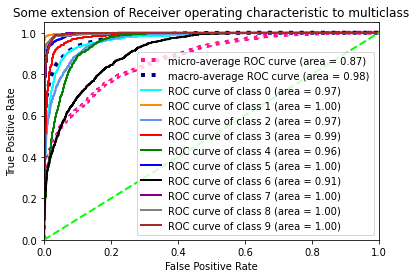

In [ ]:
compute_n_plot_roc_multiclass(LeNet_model, device, test_loader, 10)

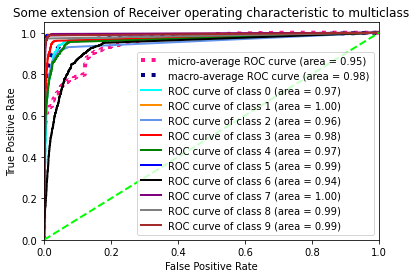

In [ ]:
compute_n_plot_roc_multiclass(FLeNet_model, device, test_loader, 10)

In [ ]:
FLeNet_model100 = regenerate_model_and_start_train(True, True, n_epochs=100)

The model has 33,620 trainable parameters
Epoch: 01 | Epoch Time: 0m 45s
	Train Loss: 1.773 | Train Acc: 46.20%
	 Val. Loss: 1.500 |  Val. Acc: 56.17%
Epoch: 02 | Epoch Time: 0m 45s
	Train Loss: 1.271 | Train Acc: 61.57%
	 Val. Loss: 1.099 |  Val. Acc: 70.67%
Epoch: 03 | Epoch Time: 0m 45s
	Train Loss: 1.014 | Train Acc: 68.27%
	 Val. Loss: 0.948 |  Val. Acc: 72.13%
Epoch: 04 | Epoch Time: 0m 45s
	Train Loss: 0.894 | Train Acc: 69.81%
	 Val. Loss: 0.861 |  Val. Acc: 72.99%
Epoch: 05 | Epoch Time: 0m 45s
	Train Loss: 0.817 | Train Acc: 71.23%
	 Val. Loss: 0.803 |  Val. Acc: 73.70%
Epoch: 06 | Epoch Time: 0m 44s
	Train Loss: 0.765 | Train Acc: 71.98%
	 Val. Loss: 0.767 |  Val. Acc: 73.91%
Epoch: 07 | Epoch Time: 0m 44s
	Train Loss: 0.727 | Train Acc: 72.61%
	 Val. Loss: 0.741 |  Val. Acc: 74.11%
Epoch: 08 | Epoch Time: 0m 44s
	Train Loss: 0.697 | Train Acc: 73.11%
	 Val. Loss: 0.727 |  Val. Acc: 74.26%
Epoch: 09 | Epoch Time: 0m 44s
	Train Loss: 0.674 | Train Acc: 73.43%
	 Val. Loss: 0.7

In [ ]:
LeNet_model100 = regenerate_model_and_start_train(False, True, n_epochs=100)

The model has 33,690 trainable parameters
Epoch: 01 | Epoch Time: 0m 44s
	Train Loss: 0.980 | Train Acc: 64.38%
	 Val. Loss: 0.729 |  Val. Acc: 71.47%
Epoch: 02 | Epoch Time: 0m 44s
	Train Loss: 0.662 | Train Acc: 74.73%
	 Val. Loss: 0.647 |  Val. Acc: 75.19%
Epoch: 03 | Epoch Time: 0m 44s
	Train Loss: 0.605 | Train Acc: 76.77%
	 Val. Loss: 0.593 |  Val. Acc: 76.96%
Epoch: 04 | Epoch Time: 0m 44s
	Train Loss: 0.570 | Train Acc: 77.89%
	 Val. Loss: 0.563 |  Val. Acc: 77.94%
Epoch: 05 | Epoch Time: 0m 44s
	Train Loss: 0.546 | Train Acc: 78.73%
	 Val. Loss: 0.548 |  Val. Acc: 78.58%
Epoch: 06 | Epoch Time: 0m 44s
	Train Loss: 0.527 | Train Acc: 79.46%
	 Val. Loss: 0.537 |  Val. Acc: 78.99%
Epoch: 07 | Epoch Time: 0m 44s
	Train Loss: 0.512 | Train Acc: 79.99%
	 Val. Loss: 0.526 |  Val. Acc: 79.45%
Epoch: 08 | Epoch Time: 0m 44s
	Train Loss: 0.499 | Train Acc: 80.49%
	 Val. Loss: 0.519 |  Val. Acc: 79.79%
Epoch: 09 | Epoch Time: 0m 44s
	Train Loss: 0.489 | Train Acc: 80.91%
	 Val. Loss: 0.5

In [ ]:
FLeNet_model100 = FLeNet()
FLeNet_model100 = FLeNet_model100.to(device)
FLeNet_model100.load_state_dict(torch.load('FLENET_fashionmnist_100_epochs_model.pt'))

LeNet_model100 = LeNet()
LeNet_model100 = LeNet_model100.to(device)
LeNet_model100.load_state_dict(torch.load('LENET_fashionmnist_100_epochs_model.pt'))

<All keys matched successfully>

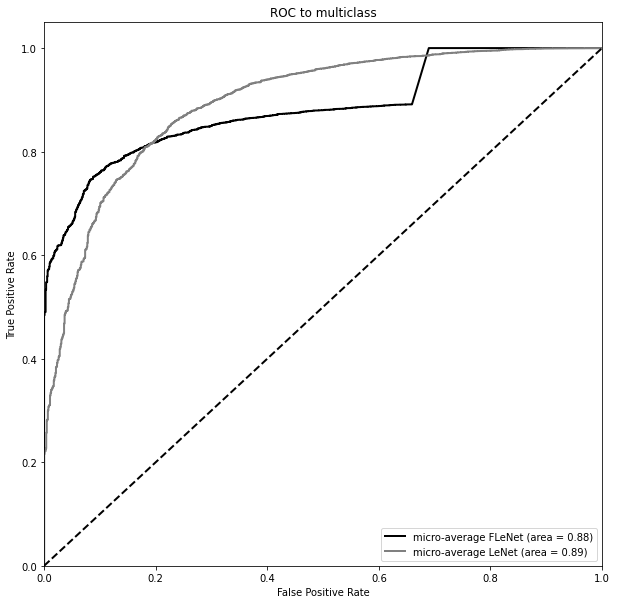

In [ ]:
compute_n_plot_roc_multiclass_for_2_models(
    FLeNet_model100, LeNet_model100,
    device, test_loader, 10,
    "FLeNet", "LeNet")

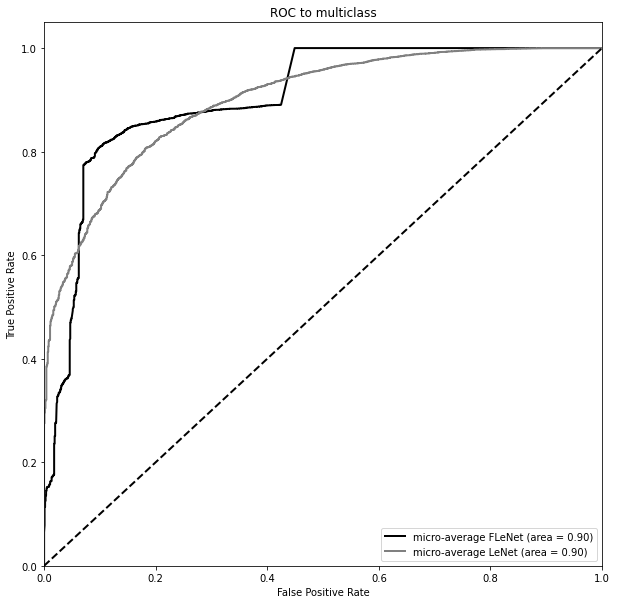

In [ ]:
compute_n_plot_roc_multiclass_for_2_models(
    FLeNet_model100, LeNet_model100,
    device, test_loader, 10,
    "FLeNet", "LeNet")

In [ ]:
FMLPNet_model100 = regenerate_model_and_start_train(True, False, n_epochs=100)

The model has 12,794 trainable parameters


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.892 | Train Acc: 71.27%
	 Val. Loss: 0.523 |  Val. Acc: 81.65%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.474 | Train Acc: 83.24%
	 Val. Loss: 0.465 |  Val. Acc: 83.63%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.430 | Train Acc: 84.80%
	 Val. Loss: 0.433 |  Val. Acc: 84.47%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.407 | Train Acc: 85.62%
	 Val. Loss: 0.428 |  Val. Acc: 84.82%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.392 | Train Acc: 86.15%
	 Val. Loss: 0.413 |  Val. Acc: 85.43%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.381 | Train Acc: 86.51%
	 Val. Loss: 0.409 |  Val. Acc: 85.65%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.372 | Train Acc: 86.79%
	 Val. Loss: 0.404 |  Val. Acc: 85.71%
Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 0.366 | Train Acc: 87.14%
	 Val. Loss: 0.402 |  Val. Acc: 85.78%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.359 | Train Acc: 87.32%
	 Val. Loss: 0.402 |  Val. Acc: 86.03%
Epoch: 10 | Epoch T

In [ ]:
MLPNet_model100 = regenerate_model_and_start_train(False, False, n_epochs=100)

The model has 13,002 trainable parameters
Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 0.903 | Train Acc: 70.63%
	 Val. Loss: 0.539 |  Val. Acc: 81.04%
Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 0.489 | Train Acc: 82.45%
	 Val. Loss: 0.483 |  Val. Acc: 82.91%
Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 0.452 | Train Acc: 84.00%
	 Val. Loss: 0.463 |  Val. Acc: 83.73%
Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.434 | Train Acc: 84.69%
	 Val. Loss: 0.451 |  Val. Acc: 84.18%
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.421 | Train Acc: 85.12%
	 Val. Loss: 0.444 |  Val. Acc: 84.39%
Epoch: 06 | Epoch Time: 0m 9s
	Train Loss: 0.411 | Train Acc: 85.50%
	 Val. Loss: 0.438 |  Val. Acc: 84.46%
Epoch: 07 | Epoch Time: 0m 9s
	Train Loss: 0.403 | Train Acc: 85.78%
	 Val. Loss: 0.432 |  Val. Acc: 84.74%
Epoch: 08 | Epoch Time: 0m 9s
	Train Loss: 0.396 | Train Acc: 86.09%
	 Val. Loss: 0.428 |  Val. Acc: 84.87%
Epoch: 09 | Epoch Time: 0m 9s
	Train Loss: 0.389 | Train Acc: 86.27%
	 Val. Loss: 0.423 |  Val

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instea

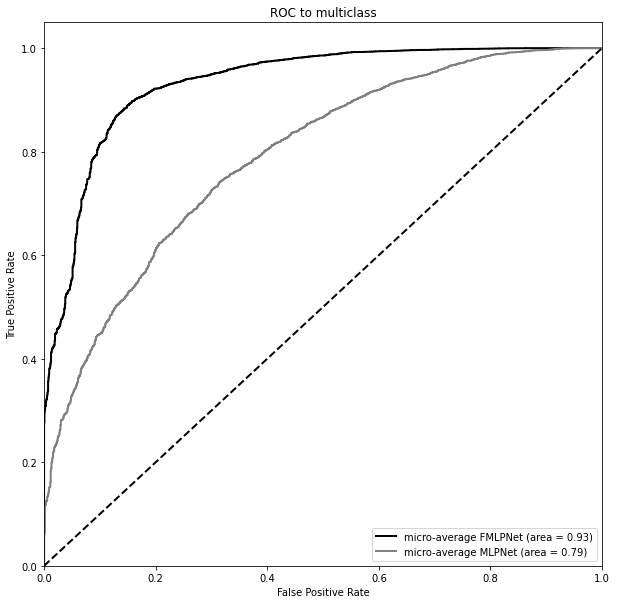

In [ ]:
compute_n_plot_roc_multiclass_for_2_models(
    FMLPNet_model100, MLPNet_model100,
    device, test_loader, 10,
    "FMLPNet", "MLPNet")

In [ ]:
FLeNet_model100 = regenerate_model_and_start_train(True, True, n_epochs=100)

The model has 33,620 trainable parameters
Epoch: 01 | Epoch Time: 0m 45s
	Train Loss: 1.613 | Train Acc: 54.52%
	 Val. Loss: 1.214 |  Val. Acc: 66.87%
Epoch: 02 | Epoch Time: 0m 45s
	Train Loss: 1.035 | Train Acc: 70.03%
	 Val. Loss: 0.883 |  Val. Acc: 75.99%
Epoch: 03 | Epoch Time: 0m 45s
	Train Loss: 0.768 | Train Acc: 79.70%
	 Val. Loss: 0.681 |  Val. Acc: 82.95%
Epoch: 04 | Epoch Time: 0m 45s
	Train Loss: 0.608 | Train Acc: 84.33%
	 Val. Loss: 0.581 |  Val. Acc: 84.76%
Epoch: 05 | Epoch Time: 0m 45s
	Train Loss: 0.522 | Train Acc: 86.33%
	 Val. Loss: 0.508 |  Val. Acc: 86.53%
Epoch: 06 | Epoch Time: 0m 45s
	Train Loss: 0.464 | Train Acc: 87.53%
	 Val. Loss: 0.458 |  Val. Acc: 87.35%
Epoch: 07 | Epoch Time: 0m 45s
	Train Loss: 0.425 | Train Acc: 88.36%
	 Val. Loss: 0.432 |  Val. Acc: 88.07%
Epoch: 08 | Epoch Time: 0m 44s
	Train Loss: 0.394 | Train Acc: 88.96%
	 Val. Loss: 0.390 |  Val. Acc: 88.41%
Epoch: 09 | Epoch Time: 0m 44s
	Train Loss: 0.336 | Train Acc: 89.63%
	 Val. Loss: 0.3

In [ ]:
LeNet_model100 = regenerate_model_and_start_train(False, True, n_epochs=100)

The model has 33,690 trainable parameters
Epoch: 01 | Epoch Time: 0m 45s
	Train Loss: 1.295 | Train Acc: 48.90%
	 Val. Loss: 1.112 |  Val. Acc: 54.58%
Epoch: 02 | Epoch Time: 0m 45s
	Train Loss: 1.059 | Train Acc: 56.79%
	 Val. Loss: 1.046 |  Val. Acc: 57.19%
Epoch: 03 | Epoch Time: 0m 45s
	Train Loss: 1.016 | Train Acc: 58.39%
	 Val. Loss: 1.014 |  Val. Acc: 58.49%
Epoch: 04 | Epoch Time: 0m 45s
	Train Loss: 0.990 | Train Acc: 59.30%
	 Val. Loss: 0.991 |  Val. Acc: 59.15%
Epoch: 05 | Epoch Time: 0m 45s
	Train Loss: 0.971 | Train Acc: 60.04%
	 Val. Loss: 0.973 |  Val. Acc: 59.88%
Epoch: 06 | Epoch Time: 0m 45s
	Train Loss: 0.956 | Train Acc: 60.62%
	 Val. Loss: 0.960 |  Val. Acc: 60.60%
Epoch: 07 | Epoch Time: 0m 45s
	Train Loss: 0.943 | Train Acc: 61.04%
	 Val. Loss: 0.951 |  Val. Acc: 60.89%
Epoch: 08 | Epoch Time: 0m 44s
	Train Loss: 0.932 | Train Acc: 61.41%
	 Val. Loss: 0.945 |  Val. Acc: 61.10%
Epoch: 09 | Epoch Time: 0m 45s
	Train Loss: 0.922 | Train Acc: 61.73%
	 Val. Loss: 0.9

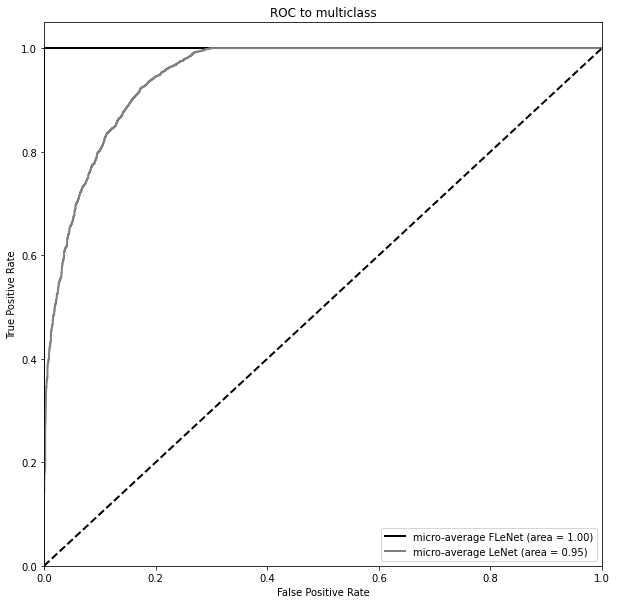

In [ ]:
compute_n_plot_roc_multiclass_for_2_models(
    FLeNet_model100, LeNet_model100,
    device, test_loader, 10,
    "FLeNet", "LeNet")

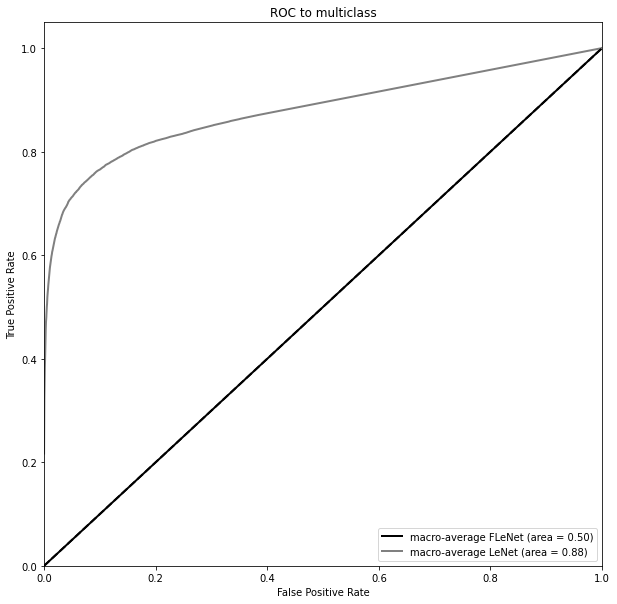

In [ ]:
# classes not balanced or the reason in low accuracy for last epochs of FLeNet??
compute_n_plot_roc_multiclass_macro_for_2_models(
    FLeNet_model100, LeNet_model100,
    device, test_loader, 10,
    "FLeNet", "LeNet")

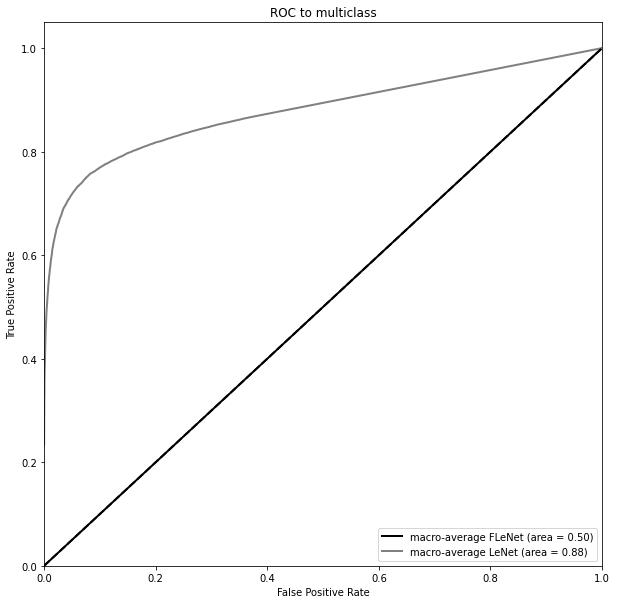

In [ ]:
# classes not balanced or the reason in low accuracy for last epochs of FLeNet??
compute_n_plot_roc_multiclass_macro_for_2_models(
    FLeNet_model100, LeNet_model100,
    device, val_loader, 10,
    "FLeNet", "LeNet")

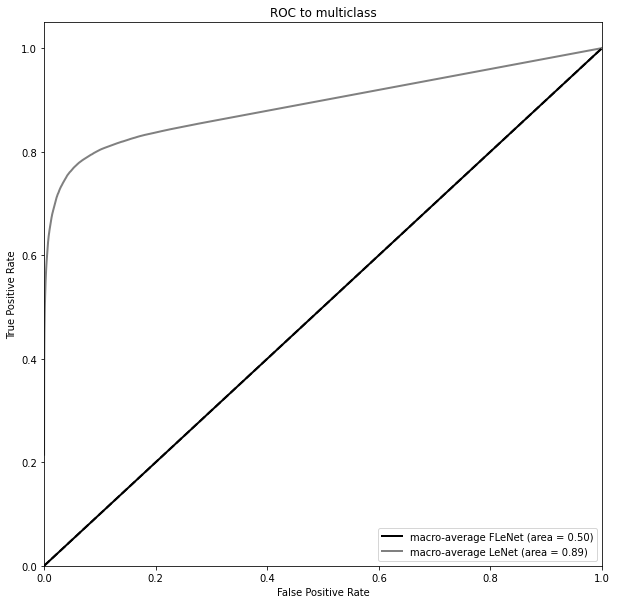

In [ ]:
# classes not balanced or the reason in low accuracy for last epochs of FLeNet??
# the answer is YES. Refer to bottom graph
compute_n_plot_roc_multiclass_macro_for_2_models(
    FLeNet_model100, LeNet_model100,
    device, train_loader, 10,
    "FLeNet", "LeNet")

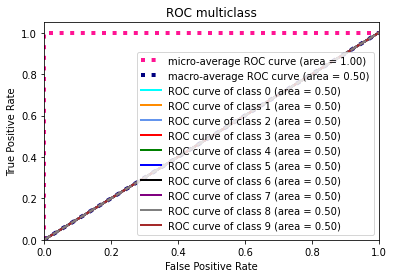

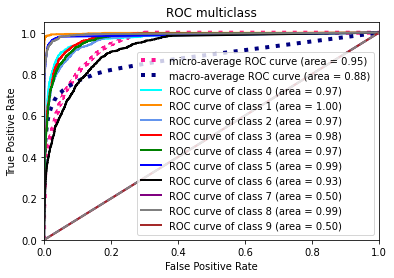

In [ ]:
compute_n_plot_roc_multiclass(FLeNet_model100, device, test_loader, 10)
compute_n_plot_roc_multiclass(LeNet_model100, device, test_loader, 10)

In [ ]:
FLeNet_model100_best = FLeNet()
FLeNet_model100_best = FLeNet_model100_best.to(device)
FLeNet_model100_best.load_state_dict(torch.load('FLENET_fashionmnist_100_epochs_model.pt'))

<All keys matched successfully>

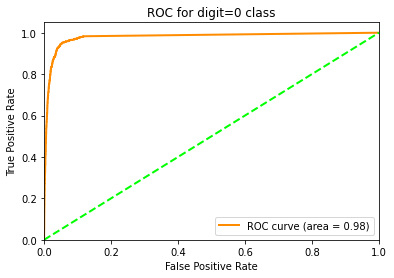

In [ ]:
compute_n_plot_roc(FLeNet_model100_best, device, test_loader, 0)

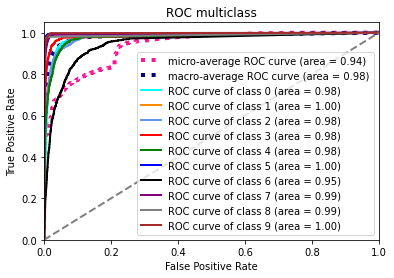

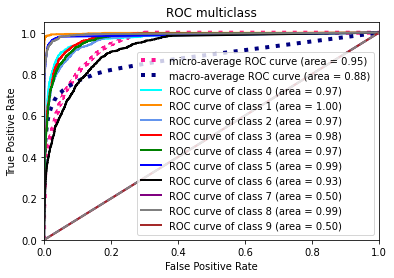

In [ ]:
compute_n_plot_roc_multiclass(FLeNet_model100_best, device, test_loader, 10)
compute_n_plot_roc_multiclass(LeNet_model100, device, test_loader, 10)

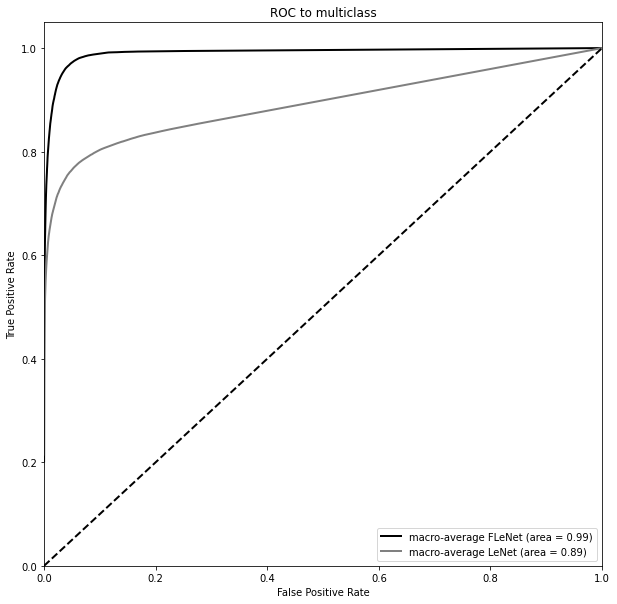

In [ ]:
compute_n_plot_roc_multiclass_macro_for_2_models(
    FLeNet_model100_best, LeNet_model100,
    device, train_loader, 10,
    "FLeNet", "LeNet")

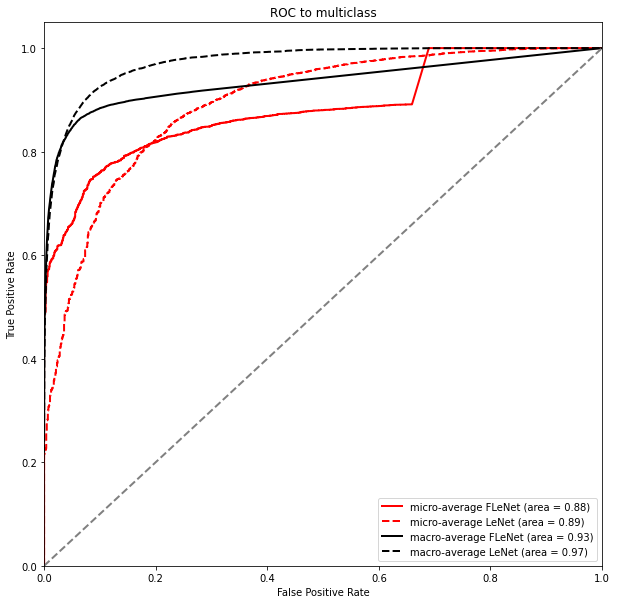

In [ ]:
FLeNet_model100_best = FLeNet()
FLeNet_model100_best = FLeNet_model100_best.to(device)
FLeNet_model100_best.load_state_dict(torch.load('FLENET_fashionmnist_100_epochs_model.pt'))
LeNet_model100_best = LeNet()
LeNet_model100_best = LeNet_model100_best.to(device)
LeNet_model100_best.load_state_dict(torch.load('LENET_fashionmnist_100_epochs_model.pt'))

compute_n_plot_roc_multiclass_macro_for_2_models(
    FLeNet_model100_best, LeNet_model100_best,
    device, test_loader, 10,
    "FLeNet", "LeNet")

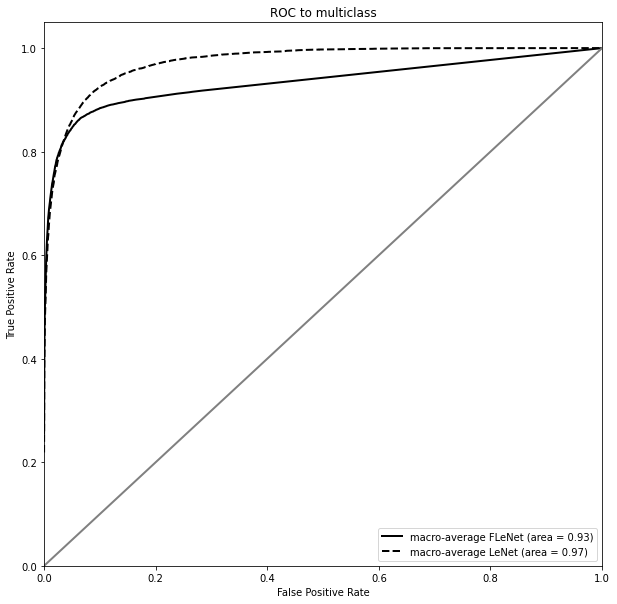

In [ ]:
compute_n_plot_roc_multiclass_macro_for_2_models(
    FLeNet_model100_best, LeNet_model100_best,
    device, test_loader, 10,
    "FLeNet", "LeNet")

In [ ]:
FLeNet_model100 = regenerate_model_and_start_train(True, True, n_epochs=100)

The model has 33,620 trainable parameters
Epoch: 01 | Epoch Time: 0m 47s
	Train Loss: 1.912 | Train Acc: 38.27%
	 Val. Loss: 1.688 |  Val. Acc: 43.49%
Epoch: 02 | Epoch Time: 0m 47s
	Train Loss: 1.594 | Train Acc: 43.59%
	 Val. Loss: 1.543 |  Val. Acc: 44.71%
Epoch: 03 | Epoch Time: 0m 48s
	Train Loss: 1.485 | Train Acc: 44.78%
	 Val. Loss: 1.464 |  Val. Acc: 45.89%
Epoch: 04 | Epoch Time: 0m 47s
	Train Loss: 1.405 | Train Acc: 47.33%
	 Val. Loss: 1.348 |  Val. Acc: 53.23%
Epoch: 05 | Epoch Time: 0m 47s
	Train Loss: 1.282 | Train Acc: 53.71%
	 Val. Loss: 1.199 |  Val. Acc: 62.39%
Epoch: 06 | Epoch Time: 0m 47s
	Train Loss: 1.098 | Train Acc: 62.24%
	 Val. Loss: 1.044 |  Val. Acc: 63.74%
Epoch: 07 | Epoch Time: 0m 47s
	Train Loss: 0.994 | Train Acc: 63.32%
	 Val. Loss: 0.982 |  Val. Acc: 63.97%
Epoch: 08 | Epoch Time: 0m 47s
	Train Loss: 0.941 | Train Acc: 63.91%
	 Val. Loss: 0.940 |  Val. Acc: 64.73%
Epoch: 09 | Epoch Time: 0m 47s
	Train Loss: 0.905 | Train Acc: 64.31%
	 Val. Loss: 0.9

In [ ]:
LeNet_model100 = regenerate_model_and_start_train(False, True, n_epochs=100)

The model has 33,690 trainable parameters
Epoch: 01 | Epoch Time: 0m 46s
	Train Loss: 1.658 | Train Acc: 39.69%
	 Val. Loss: 1.347 |  Val. Acc: 48.11%
Epoch: 02 | Epoch Time: 0m 46s
	Train Loss: 1.294 | Train Acc: 50.15%
	 Val. Loss: 1.266 |  Val. Acc: 51.07%
Epoch: 03 | Epoch Time: 0m 46s
	Train Loss: 1.092 | Train Acc: 59.47%
	 Val. Loss: 1.037 |  Val. Acc: 61.26%
Epoch: 04 | Epoch Time: 0m 46s
	Train Loss: 1.012 | Train Acc: 62.06%
	 Val. Loss: 1.018 |  Val. Acc: 61.55%
Epoch: 05 | Epoch Time: 0m 46s
	Train Loss: 0.988 | Train Acc: 62.59%
	 Val. Loss: 0.997 |  Val. Acc: 62.09%
Epoch: 06 | Epoch Time: 0m 45s
	Train Loss: 0.970 | Train Acc: 63.00%
	 Val. Loss: 0.984 |  Val. Acc: 62.63%
Epoch: 07 | Epoch Time: 0m 46s
	Train Loss: 0.955 | Train Acc: 63.41%
	 Val. Loss: 0.975 |  Val. Acc: 62.91%
Epoch: 08 | Epoch Time: 0m 46s
	Train Loss: 0.943 | Train Acc: 63.69%
	 Val. Loss: 0.966 |  Val. Acc: 63.04%
Epoch: 09 | Epoch Time: 0m 45s
	Train Loss: 0.932 | Train Acc: 63.93%
	 Val. Loss: 0.9

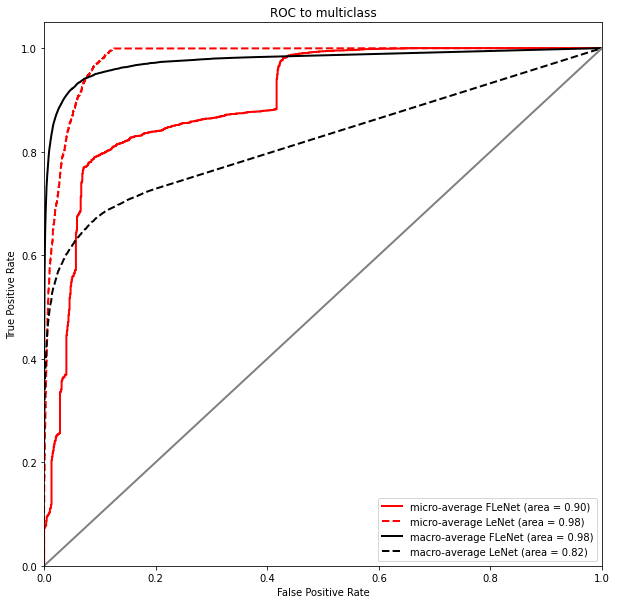

In [ ]:
compute_n_plot_roc_multiclass_macro_for_2_models(
    FLeNet_model100, LeNet_model100,
    device, test_loader, 10,
    "FLeNet", "LeNet")

In [ ]:
FLeNet_model100 = FLeNet()
FLeNet_model100 = FLeNet_model100.to(device)
FLeNet_model100.load_state_dict(torch.load('FLENET_fashionmnist_100_epochs_model.pt'))

<All keys matched successfully>

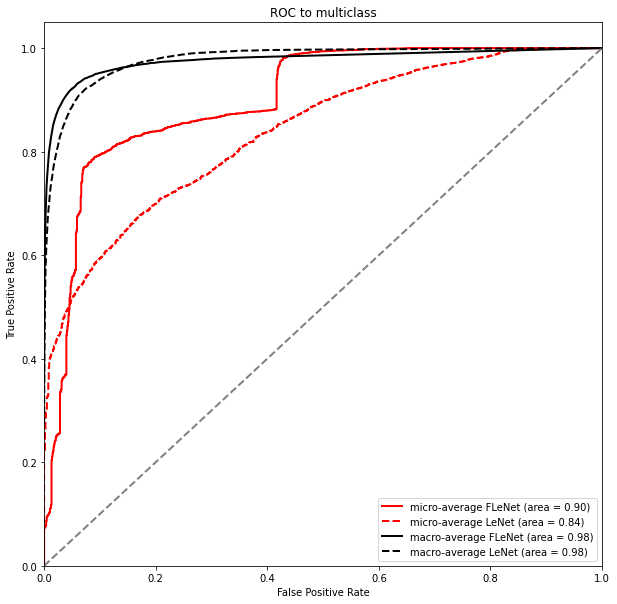

In [ ]:
compute_n_plot_roc_multiclass_macro_for_2_models(
    FLeNet_model100, LeNet_model100,
    device, test_loader, 10,
    "FLeNet", "LeNet")

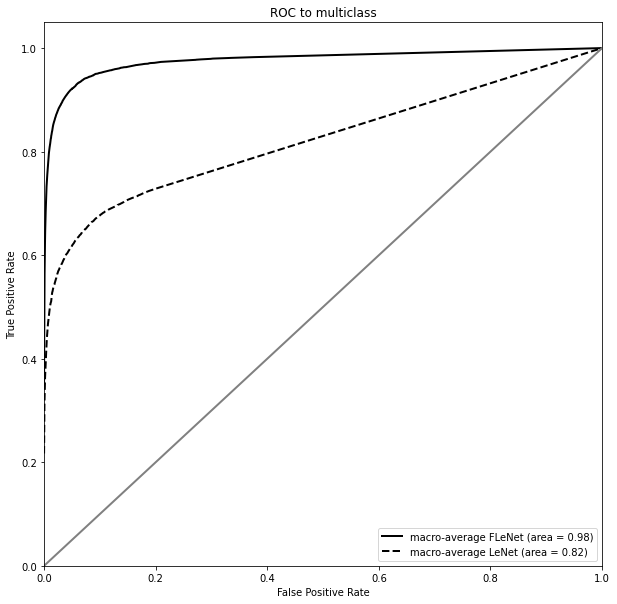

In [ ]:
compute_n_plot_roc_multiclass_macro_for_2_models(
    FLeNet_model100, LeNet_model100,
    device, test_loader, 10,
    "FLeNet", "LeNet")

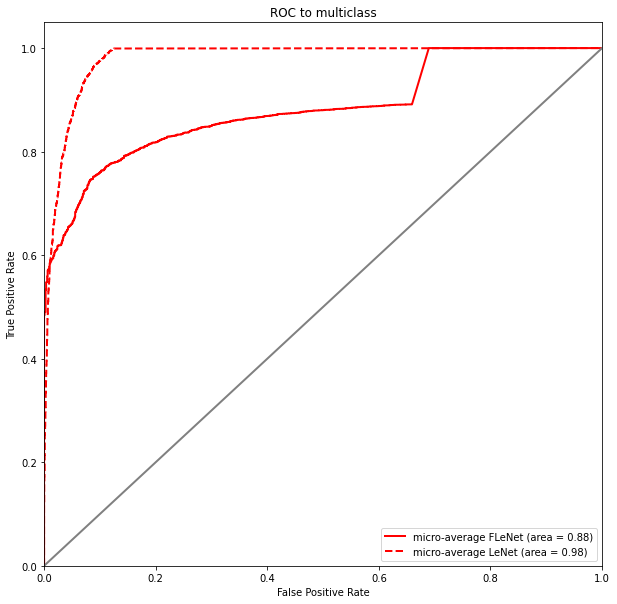

In [ ]:
compute_n_plot_roc_multiclass_macro_for_2_models(
    FLeNet_model100_best, LeNet_model100,
    device, test_loader, 10,
    "FLeNet", "LeNet")

In [ ]:
FMLPNet_model100 = regenerate_model_and_start_train(True, False, n_epochs=100)

The model has 12,794 trainable parameters


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 01 | Epoch Time: 0m 13s
	Train Loss: 0.905 | Train Acc: 71.52%
	 Val. Loss: 0.537 |  Val. Acc: 81.17%
Epoch: 02 | Epoch Time: 0m 13s
	Train Loss: 0.482 | Train Acc: 82.99%
	 Val. Loss: 0.463 |  Val. Acc: 83.71%
Epoch: 03 | Epoch Time: 0m 14s
	Train Loss: 0.431 | Train Acc: 84.67%
	 Val. Loss: 0.439 |  Val. Acc: 84.49%
Epoch: 04 | Epoch Time: 0m 14s
	Train Loss: 0.406 | Train Acc: 85.63%
	 Val. Loss: 0.422 |  Val. Acc: 85.25%
Epoch: 05 | Epoch Time: 0m 13s
	Train Loss: 0.391 | Train Acc: 86.07%
	 Val. Loss: 0.412 |  Val. Acc: 85.59%
Epoch: 06 | Epoch Time: 0m 13s
	Train Loss: 0.379 | Train Acc: 86.46%
	 Val. Loss: 0.403 |  Val. Acc: 85.91%
Epoch: 07 | Epoch Time: 0m 14s
	Train Loss: 0.369 | Train Acc: 86.80%
	 Val. Loss: 0.399 |  Val. Acc: 86.10%
Epoch: 08 | Epoch Time: 0m 13s
	Train Loss: 0.360 | Train Acc: 87.06%
	 Val. Loss: 0.395 |  Val. Acc: 86.20%
Epoch: 09 | Epoch Time: 0m 13s
	Train Loss: 0.354 | Train Acc: 87.33%
	 Val. Loss: 0.394 |  Val. Acc: 86.36%
Epoch: 10 | Epoch T

In [ ]:
MLPNet_model100 = regenerate_model_and_start_train(False, False, n_epochs=100)

The model has 13,002 trainable parameters
Epoch: 01 | Epoch Time: 0m 12s
	Train Loss: 1.324 | Train Acc: 60.06%
	 Val. Loss: 1.051 |  Val. Acc: 66.52%
Epoch: 02 | Epoch Time: 0m 12s
	Train Loss: 1.006 | Train Acc: 68.22%
	 Val. Loss: 0.996 |  Val. Acc: 68.19%
Epoch: 03 | Epoch Time: 0m 12s
	Train Loss: 0.970 | Train Acc: 69.16%
	 Val. Loss: 0.972 |  Val. Acc: 68.96%
Epoch: 04 | Epoch Time: 0m 12s
	Train Loss: 0.950 | Train Acc: 69.54%
	 Val. Loss: 0.958 |  Val. Acc: 69.26%
Epoch: 05 | Epoch Time: 0m 12s
	Train Loss: 0.936 | Train Acc: 69.93%
	 Val. Loss: 0.949 |  Val. Acc: 69.44%
Epoch: 06 | Epoch Time: 0m 12s
	Train Loss: 0.925 | Train Acc: 70.25%
	 Val. Loss: 0.940 |  Val. Acc: 69.81%
Epoch: 07 | Epoch Time: 0m 12s
	Train Loss: 0.916 | Train Acc: 70.50%
	 Val. Loss: 0.934 |  Val. Acc: 69.78%
Epoch: 08 | Epoch Time: 0m 12s
	Train Loss: 0.908 | Train Acc: 70.72%
	 Val. Loss: 0.929 |  Val. Acc: 69.85%
Epoch: 09 | Epoch Time: 0m 12s
	Train Loss: 0.902 | Train Acc: 70.88%
	 Val. Loss: 0.9

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instea

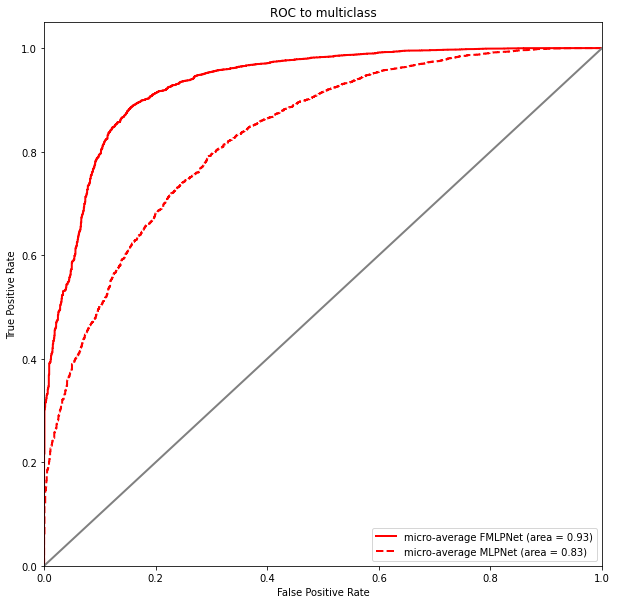

In [ ]:
compute_n_plot_roc_multiclass_macro_for_2_models(
    FMLPNet_model100, MLPNet_model100,
    device, test_loader, 10,
    "FMLPNet", "MLPNet")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instea

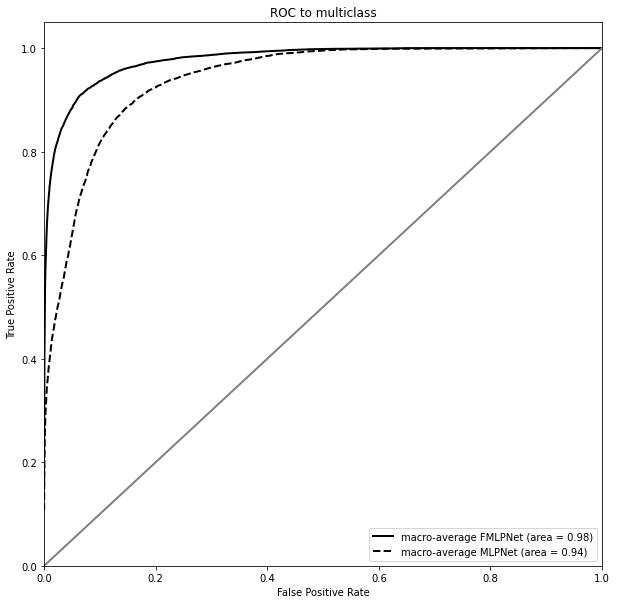

In [ ]:
compute_n_plot_roc_multiclass_macro_for_2_models(
    FMLPNet_model100, MLPNet_model100,
    device, test_loader, 10,
    "FMLPNet", "MLPNet")

In [ ]:
# LENET
epochs = range(100)

lenet_train_acc = [0.3969,0.5015,0.5947,0.6206,0.6259,0.6300,0.6341,0.6369,0.6393,0.6418,0.6437,0.6455,0.6470,0.6485,0.6500,0.6520,0.6533,0.6550,0.6560,0.6571,0.6583,0.6591,0.6604,0.6620,0.6631,0.6638,0.6649,0.6660,0.6672,0.6678,0.6685,0.6695,0.6700,0.6708,0.6714,0.6722,0.6726,0.6734,0.6741,0.6749,0.6758,0.6766,0.6769,0.6774,0.6778,0.6781,0.6779,0.6784,0.6785,0.6789,0.6791,0.6798,0.6797,0.6801,0.6798,0.6801,0.6797,0.6799,0.6792,0.6790,0.6789,0.6780,0.6795,0.6808,0.6816,0.6820,0.6832,0.6836,0.6835,0.6842,0.6852,0.6858,0.6865,0.6862,0.6871,0.6878,0.6876,0.6882,0.6886,0.6887,0.6886,0.6882,0.6886,0.6891,0.6894,0.6899,0.6909,0.6906,0.6898,0.6910,0.6909,0.6910,0.6908,0.6908,0.6900,0.6905,0.6904,0.6905,0.6909,0.6911]
flenet_train_acc = [0.3827,0.4359,0.4478,0.4733,0.5371,0.6224,0.6332,0.6391,0.6431,0.6466,0.6496,0.6523,0.6553,0.6572,0.6585,0.6606,0.7296,0.7505,0.7532,0.8334,0.8891,0.9339,0.9373,0.9387,0.9401,0.9426,0.9443,0.9459,0.9496,0.9513,0.9520,0.9520,0.9525,0.9540,0.9550,0.9566,0.9570,0.9588,0.9603,0.9615,0.9631,0.9635,0.9614,0.9638,0.9627,0.9643,0.9633,0.9635,0.9627,0.9659,0.9635,0.9659,0.9684,0.9701,0.9698,0.9720,0.9694,0.9739,0.9757,0.9746,0.9753,0.9741,0.9730,0.9737,0.9764,0.9758,0.9766,0.9770,0.9763,0.9775,0.9782,0.9776,0.9796,0.9806,0.9792,0.9797,0.9791,0.9804,0.9783,0.9772,0.9759,0.9772,0.9758,0.9781,0.9795,0.9812,0.9816,0.9826,0.9802,0.9801,0.9829,0.9813,0.9822,0.9818,0.9817,0.9795,0.9805,0.9818,0.9816,0.9821]

lenet_train_loss = [1.658,1.294,1.092,1.012,0.988,0.970,0.955,0.943,0.932,0.923,0.914,0.907,0.900,0.893,0.887,0.882,0.876,0.871,0.866,0.861,0.857,0.853,0.848,0.844,0.840,0.837,0.833,0.829,0.826,0.822,0.819,0.816,0.813,0.810,0.807,0.805,0.802,0.799,0.797,0.794,0.792,0.789,0.787,0.785,0.783,0.782,0.782,0.780,0.780,0.778,0.776,0.773,0.772,0.771,0.771,0.771,0.771,0.770,0.771,0.772,0.771,0.775,0.770,0.764,0.762,0.759,0.755,0.754,0.753,0.751,0.749,0.746,0.743,0.742,0.741,0.739,0.739,0.737,0.735,0.734,0.733,0.734,0.732,0.732,0.730,0.728,0.726,0.726,0.727,0.725,0.724,0.723,0.724,0.724,0.726,0.724,0.724,0.723,0.722,0.721]
flenet_train_loss = [1.912,1.594,1.485,1.405,1.282,1.098,0.994,0.941,0.905,0.880,0.860,0.844,0.829,0.814,0.804,0.794,0.710,0.622,0.589,0.494,0.412,0.333,0.298,0.278,0.260,0.246,0.227,0.201,0.187,0.176,0.172,0.169,0.163,0.157,0.153,0.148,0.144,0.139,0.134,0.129,0.126,0.122,0.127,0.121,0.122,0.117,0.118,0.116,0.119,0.112,0.115,0.110,0.104,0.099,0.099,0.094,0.099,0.088,0.084,0.085,0.085,0.087,0.090,0.088,0.080,0.081,0.081,0.079,0.081,0.078,0.076,0.078,0.072,0.069,0.072,0.070,0.072,0.069,0.075,0.079,0.081,0.078,0.080,0.074,0.071,0.067,0.064,0.062,0.071,0.062,0.066,0.064,0.075,0.061,0.065,0.0600,0.064,0.062,0.061,0.063]

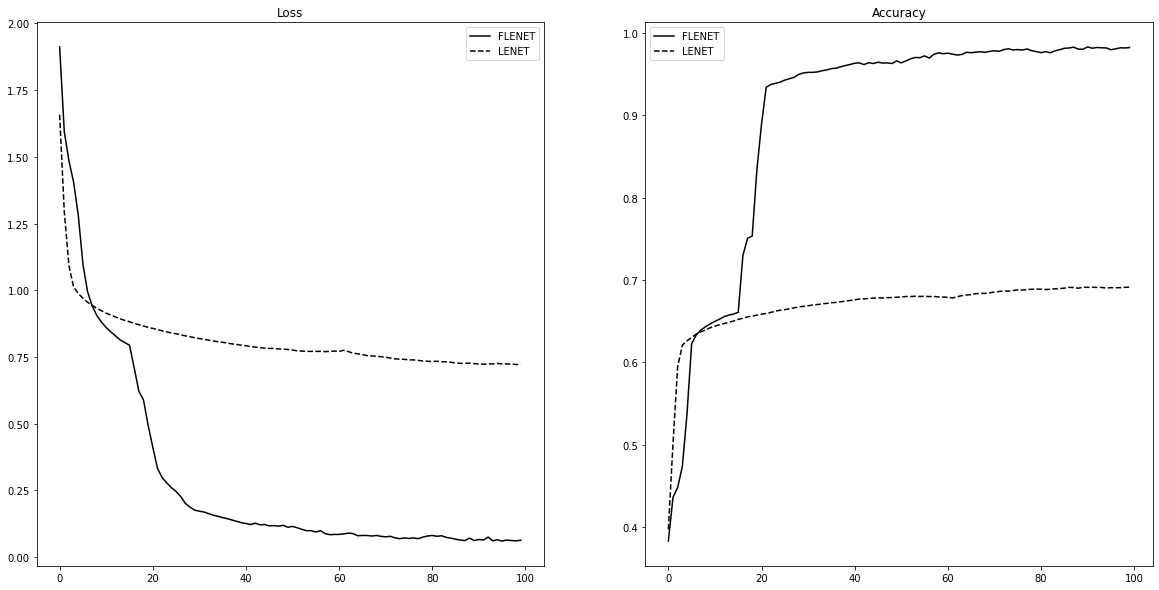

In [ ]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(1, 2, figsize=(20, 10))
axis[0].set_title("Loss")
fal_loss_line, = axis[0].plot(epochs, flenet_train_loss, color='black', label='FLENET')
crisp_loss_line, = axis[0].plot(epochs, lenet_train_loss, '--', color='black', label='LENET')
axis[0].legend(handles=[fal_loss_line, crisp_loss_line])

axis[1].set_title("Accuracy")
fal_acc_line, = axis[1].plot(epochs, flenet_train_acc, color='black', label='FLENET')
crisp_acc_line, = axis[1].plot(epochs, lenet_train_acc, 'k--', color='black', label='LENET')
axis[1].legend(handles=[fal_acc_line, crisp_acc_line])

In [ ]:
# MLP
epochs = range(100)

mlp_train_acc = [0.6006,0.6822,0.6916,0.6954,0.6993,0.7025,0.7050,0.7072,0.7088,0.7109,0.7123,0.7134,0.7499,0.7780,0.8019,0.8726,0.8750,0.8765,0.8774,0.8783,0.8793,0.8800,0.8808,0.8816,0.8826,0.8832,0.8843,0.8852,0.8858,0.8864,0.8866,0.8869,0.8875,0.8880,0.8879,0.8884,0.8887,0.8890,0.8895,0.8897,0.8902,0.8906,0.8907,0.8912,0.8914,0.8920,0.8919,0.8926,0.8925,0.8930,0.8938,0.8939,0.8943,0.8946,0.8952,0.8953,0.8954,0.8961,0.8963,0.8964,0.8968,0.8971,0.8971,0.8976,0.8976,0.8982,0.8985,0.8988,0.8986,0.8990,0.8989,0.8989,0.8988,0.8991,0.8996,0.8995,0.8998,0.9001,0.9002,0.9001,0.9004,0.9009,0.9013,0.9015,0.9015,0.9016,0.9020,0.9020,0.9024,0.9023,0.9026,0.9030,0.9028,0.9034,0.9035,0.9037,0.9039,0.9041,0.9044,0.9046]
fmlp_train_acc = [0.7152,0.8299,0.8467,0.8563,0.8607,0.8646,0.8680,0.8706,0.8733,0.8750,0.8777,0.8787,0.8801,0.8811,0.8829,0.8846,0.8857,0.8852,0.8864,0.8871,0.8875,0.8882,0.8892,0.8894,0.8900,0.8902,0.8914,0.8909,0.8920,0.8934,0.8941,0.8947,0.8955,0.8948,0.8965,0.8966,0.8970,0.8983,0.8975,0.8979,0.8989,0.8979,0.8994,0.8998,0.9000,0.9002,0.9009,0.9011,0.9018,0.9021,0.9020,0.9025,0.9031,0.9034,0.9029,0.9046,0.9045,0.9035,0.9047,0.9052,0.9056,0.9056,0.9053,0.9054,0.9062,0.9067,0.9066,0.9076,0.9064,0.9076,0.9085,0.9072,0.9072,0.9083,0.9071,0.9080,0.9087,0.9087,0.9091,0.9086,0.9084,0.9094,0.9093,0.9095,0.9104,0.9096,0.9107,0.9102,0.9108,0.9103,0.9112,0.9102,0.9106,0.9101,0.9103,0.9111,0.9115,0.9104,0.9116,0.9103]

mlp_train_loss = [1.324,1.006,0.970,0.950,0.936,0.925,0.916,0.908,0.902,0.896,0.891,0.887,0.769,0.639,0.574,0.369,0.361,0.356,0.351,0.348,0.345,0.342,0.339,0.337,0.335,0.332,0.330,0.328,0.326,0.325,0.323,0.321,0.320,0.318,0.317,0.316,0.314,0.313,0.312,0.311,0.309,0.308,0.307,0.306,0.305,0.304,0.303,0.302,0.301,0.300,0.299,0.298,0.297,0.297,0.296,0.295,0.294,0.294,0.293,0.292,0.291,0.290,0.290,0.289,0.288,0.288,0.287,0.287,0.286,0.285,0.285,0.284,0.284,0.283,0.282,0.282,0.281,0.281,0.281,0.280,0.279,0.279,0.278,0.278,0.277,0.277,0.276,0.276,0.276,0.275,0.275,0.274,0.274,0.273,0.273,0.272,0.272,0.271,0.271,0.271]
fmlp_train_loss = [0.905,0.482,0.431,0.406,0.391,0.379,0.369,0.360,0.354,0.349,0.343,0.338,0.335,0.332,0.328,0.326,0.322,0.320,0.318,0.316,0.314,0.312,0.310,0.309,0.308,0.307,0.305,0.304,0.302,0.300,0.298,0.296,0.296,0.294,0.292,0.291,0.290,0.289,0.288,0.286,0.285,0.286,0.285,0.282,0.283,0.282,0.279,0.280,0.278,0.278,0.277,0.276,0.275,0.274,0.274,0.272,0.274,0.274,0.273,0.269,0.269,0.268,0.269,0.270,0.268,0.266,0.267,0.264,0.267,0.264,0.263,0.265,0.263,0.262,0.264,0.261,0.261,0.260,0.260,0.262,0.261,0.260,0.258,0.259,0.256,0.258,0.256,0.257,0.255,0.255,0.256,0.255,0.253,0.256,0.254,0.254,0.253,0.255,0.251,0.254]

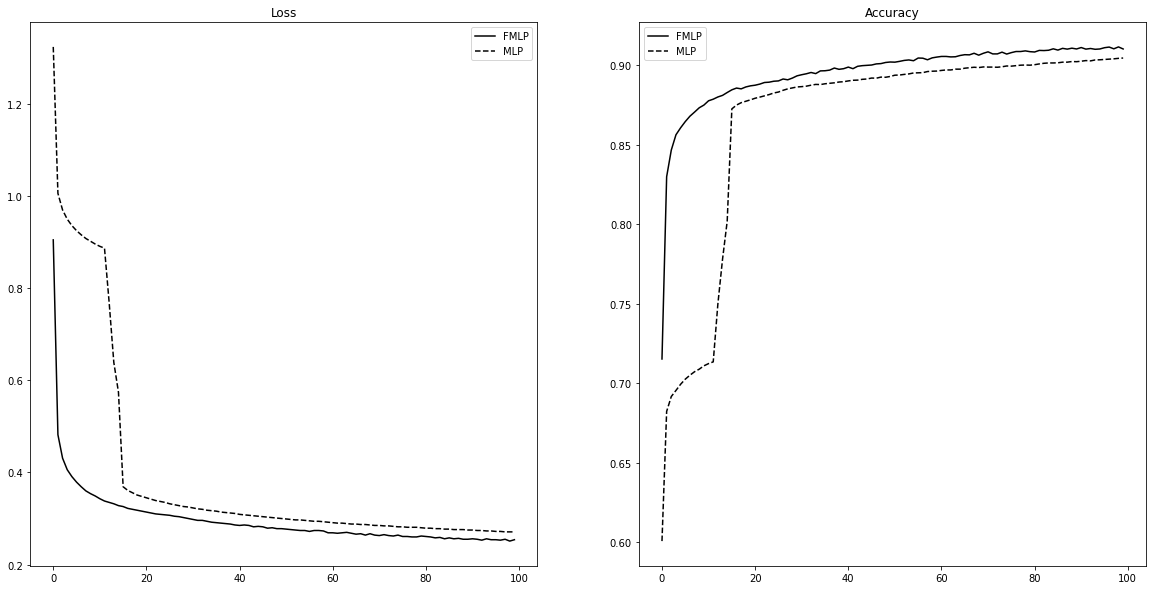

In [ ]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(1, 2, figsize=(20, 10))
axis[0].set_title("Loss")
fal_loss_line, = axis[0].plot(epochs, fmlp_train_loss, color='black', label='FMLP')
crisp_loss_line, = axis[0].plot(epochs, mlp_train_loss, '--', color='black', label='MLP')
axis[0].legend(handles=[fal_loss_line, crisp_loss_line])

axis[1].set_title("Accuracy")
fal_acc_line, = axis[1].plot(epochs, fmlp_train_acc, color='black', label='FMLP')
crisp_acc_line, = axis[1].plot(epochs, mlp_train_acc, 'k--', color='black', label='MLP')
axis[1].legend(handles=[fal_acc_line, crisp_acc_line])

In [ ]:
FMLPNet_model100 = regenerate_model_and_start_train(True, False, n_epochs=100)

The model has 12,794 trainable parameters


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 01 | Epoch Time: 0m 19s
	Train Loss: 0.909 | Train Acc: 70.20%
	 Val. Loss: 0.531 |  Val. Acc: 81.11%
Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 0.478 | Train Acc: 83.06%
	 Val. Loss: 0.459 |  Val. Acc: 83.36%
Epoch: 03 | Epoch Time: 0m 12s
	Train Loss: 0.451 | Train Acc: 84.21%
	 Val. Loss: 0.474 |  Val. Acc: 83.29%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.430 | Train Acc: 84.82%
	 Val. Loss: 0.450 |  Val. Acc: 83.96%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.407 | Train Acc: 85.59%
	 Val. Loss: 0.441 |  Val. Acc: 84.25%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.394 | Train Acc: 86.08%
	 Val. Loss: 0.424 |  Val. Acc: 84.80%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.382 | Train Acc: 86.40%
	 Val. Loss: 0.427 |  Val. Acc: 84.63%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.375 | Train Acc: 86.65%
	 Val. Loss: 0.434 |  Val. Acc: 84.70%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.368 | Train Acc: 86.89%
	 Val. Loss: 0.412 |  Val. Acc: 85.26%
Epoch: 10 | Epoch T

In [ ]:
MLPNet_model100 = regenerate_model_and_start_train(False, False, n_epochs=100)

The model has 13,002 trainable parameters
Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.937 | Train Acc: 68.80%
	 Val. Loss: 0.540 |  Val. Acc: 80.56%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.490 | Train Acc: 82.36%
	 Val. Loss: 0.477 |  Val. Acc: 83.03%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.448 | Train Acc: 84.07%
	 Val. Loss: 0.452 |  Val. Acc: 83.88%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.426 | Train Acc: 84.90%
	 Val. Loss: 0.436 |  Val. Acc: 84.61%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.411 | Train Acc: 85.39%
	 Val. Loss: 0.427 |  Val. Acc: 84.87%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.400 | Train Acc: 85.74%
	 Val. Loss: 0.420 |  Val. Acc: 85.31%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.392 | Train Acc: 86.05%
	 Val. Loss: 0.414 |  Val. Acc: 85.43%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.385 | Train Acc: 86.38%
	 Val. Loss: 0.410 |  Val. Acc: 85.49%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.378 | Train Acc: 86.60%
	 Val. Loss: 0.4

In [ ]:
FMLPNet_model100 = regenerate_model_and_start_train(True, False, n_epochs=100)

The model has 12,794 trainable parameters


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.875 | Train Acc: 73.47%
	 Val. Loss: 0.514 |  Val. Acc: 81.36%
Epoch: 02 | Epoch Time: 0m 12s
	Train Loss: 0.470 | Train Acc: 83.23%
	 Val. Loss: 0.452 |  Val. Acc: 84.04%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.430 | Train Acc: 84.84%
	 Val. Loss: 0.432 |  Val. Acc: 84.51%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.406 | Train Acc: 85.47%
	 Val. Loss: 0.412 |  Val. Acc: 85.38%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.391 | Train Acc: 86.01%
	 Val. Loss: 0.408 |  Val. Acc: 85.48%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.381 | Train Acc: 86.38%
	 Val. Loss: 0.413 |  Val. Acc: 85.08%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.372 | Train Acc: 86.60%
	 Val. Loss: 0.409 |  Val. Acc: 85.26%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.365 | Train Acc: 86.90%
	 Val. Loss: 0.403 |  Val. Acc: 85.56%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.359 | Train Acc: 87.09%
	 Val. Loss: 0.408 |  Val. Acc: 85.40%
Epoch: 10 | Epoch T

In [ ]:
MLPNet_model100 = regenerate_model_and_start_train(False, False, n_epochs=100)

The model has 13,002 trainable parameters
Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 2.003 | Train Acc: 34.32%
	 Val. Loss: 1.835 |  Val. Acc: 38.71%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 1.754 | Train Acc: 41.35%
	 Val. Loss: 1.573 |  Val. Acc: 47.48%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 1.531 | Train Acc: 48.10%
	 Val. Loss: 1.520 |  Val. Acc: 48.08%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 1.129 | Train Acc: 62.71%
	 Val. Loss: 1.015 |  Val. Acc: 65.99%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.972 | Train Acc: 67.28%
	 Val. Loss: 0.989 |  Val. Acc: 66.31%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.952 | Train Acc: 67.63%
	 Val. Loss: 0.977 |  Val. Acc: 66.42%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.940 | Train Acc: 67.90%
	 Val. Loss: 0.969 |  Val. Acc: 66.59%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.931 | Train Acc: 68.14%
	 Val. Loss: 0.965 |  Val. Acc: 66.67%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.924 | Train Acc: 68.27%
	 Val. Loss: 0.9

In [ ]:
FMLPNet_model100 = regenerate_model_and_start_train(True, False, n_epochs=100)

The model has 12,794 trainable parameters


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.898 | Train Acc: 71.71%
	 Val. Loss: 0.531 |  Val. Acc: 80.95%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.471 | Train Acc: 83.32%
	 Val. Loss: 0.465 |  Val. Acc: 83.16%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.424 | Train Acc: 85.15%
	 Val. Loss: 0.430 |  Val. Acc: 84.84%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.402 | Train Acc: 85.77%
	 Val. Loss: 0.436 |  Val. Acc: 84.57%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.387 | Train Acc: 86.40%
	 Val. Loss: 0.418 |  Val. Acc: 85.26%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.379 | Train Acc: 86.67%
	 Val. Loss: 0.417 |  Val. Acc: 85.38%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.368 | Train Acc: 87.06%
	 Val. Loss: 0.410 |  Val. Acc: 85.83%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.361 | Train Acc: 87.21%
	 Val. Loss: 0.406 |  Val. Acc: 85.77%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.356 | Train Acc: 87.47%
	 Val. Loss: 0.402 |  Val. Acc: 86.05%
Epoch: 10 | Epoch T

In [ ]:
MLPNet_model100 = regenerate_model_and_start_train(False, False, n_epochs=100)

The model has 13,002 trainable parameters
Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.796 | Train Acc: 72.04%
	 Val. Loss: 0.532 |  Val. Acc: 80.91%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.488 | Train Acc: 82.53%
	 Val. Loss: 0.476 |  Val. Acc: 83.36%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.450 | Train Acc: 84.09%
	 Val. Loss: 0.455 |  Val. Acc: 84.08%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.430 | Train Acc: 84.78%
	 Val. Loss: 0.443 |  Val. Acc: 84.21%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.416 | Train Acc: 85.25%
	 Val. Loss: 0.433 |  Val. Acc: 84.48%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.405 | Train Acc: 85.60%
	 Val. Loss: 0.427 |  Val. Acc: 84.65%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.397 | Train Acc: 85.89%
	 Val. Loss: 0.420 |  Val. Acc: 84.96%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.389 | Train Acc: 86.19%
	 Val. Loss: 0.415 |  Val. Acc: 85.06%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.383 | Train Acc: 86.38%
	 Val. Loss: 0.4

In [ ]:
FMLPNet_model100 = regenerate_model_and_start_train(True, False, n_epochs=100)

The model has 12,794 trainable parameters


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.887 | Train Acc: 72.56%
	 Val. Loss: 0.531 |  Val. Acc: 81.01%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.485 | Train Acc: 82.88%
	 Val. Loss: 0.485 |  Val. Acc: 82.65%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.439 | Train Acc: 84.26%
	 Val. Loss: 0.464 |  Val. Acc: 83.08%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.415 | Train Acc: 85.08%
	 Val. Loss: 0.442 |  Val. Acc: 84.22%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.399 | Train Acc: 85.68%
	 Val. Loss: 0.432 |  Val. Acc: 84.57%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.386 | Train Acc: 86.17%
	 Val. Loss: 0.428 |  Val. Acc: 84.80%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.376 | Train Acc: 86.54%
	 Val. Loss: 0.418 |  Val. Acc: 85.10%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.370 | Train Acc: 86.73%
	 Val. Loss: 0.418 |  Val. Acc: 85.10%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.364 | Train Acc: 86.97%
	 Val. Loss: 0.414 |  Val. Acc: 85.24%
Epoch: 10 | Epoch T

In [ ]:
MLPNet_model100 = regenerate_model_and_start_train(False, False, n_epochs=100)

The model has 13,002 trainable parameters
Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.832 | Train Acc: 72.79%
	 Val. Loss: 0.534 |  Val. Acc: 81.06%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.486 | Train Acc: 82.71%
	 Val. Loss: 0.479 |  Val. Acc: 82.89%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.447 | Train Acc: 84.09%
	 Val. Loss: 0.458 |  Val. Acc: 83.82%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.427 | Train Acc: 84.81%
	 Val. Loss: 0.446 |  Val. Acc: 84.14%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.414 | Train Acc: 85.28%
	 Val. Loss: 0.438 |  Val. Acc: 84.42%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.404 | Train Acc: 85.63%
	 Val. Loss: 0.430 |  Val. Acc: 84.79%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.396 | Train Acc: 85.87%
	 Val. Loss: 0.424 |  Val. Acc: 85.05%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.388 | Train Acc: 86.14%
	 Val. Loss: 0.419 |  Val. Acc: 85.21%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.382 | Train Acc: 86.45%
	 Val. Loss: 0.4

In [ ]:
MLPNet_model100 = regenerate_model_and_start_train(False, False, n_epochs=1)
FMLPNet_model100 = regenerate_model_and_start_train(True, False, n_epochs=1)
LeNet_model100 = regenerate_model_and_start_train(False, True, n_epochs=1)
FLeNet_model100 = regenerate_model_and_start_train(True, True, n_epochs=1)

The model has 13,002 trainable parameters
Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 1.048 | Train Acc: 66.89%
	 Val. Loss: 0.812 |  Val. Acc: 73.21%
Test Loss: 0.825 | Test Acc: 72.83%
The model has 12,794 trainable parameters


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.910 | Train Acc: 71.45%
	 Val. Loss: 0.527 |  Val. Acc: 81.17%
		 FAL hyperparameters:
			 A: Parameter containing:
tensor([[0.2340, 0.1483, 0.3390, 0.2987, 0.2542, 0.3923, 0.2157, 0.2787, 0.1429,
         0.3384, 0.2173, 0.2647, 0.4176, 0.1719, 0.2534, 0.3279]],
       requires_grad=True)
			 P: Parameter containing:
tensor([[1.3517, 1.4105, 1.3374, 1.3559, 1.3121, 1.2475, 1.4095, 1.4036, 1.4395,
         1.3500, 1.3629, 1.3502, 1.2928, 1.3571, 1.3822, 1.3225]],
       requires_grad=True)
			 N: Parameter containing:
tensor([[1.4067, 1.4775, 1.2941, 1.2912, 1.4075, 1.2877, 1.3874, 1.3106, 1.5122,
         1.2809, 1.3889, 1.3835, 1.2325, 1.4711, 1.3997, 1.2903]],
       requires_grad=True)
Test Loss: 0.539 | Test Acc: 80.52%
The model has 33,690 trainable parameters
Epoch: 01 | Epoch Time: 0m 47s
	Train Loss: 1.295 | Train Acc: 53.18%
	 Val. Loss: 1.130 |  Val. Acc: 57.99%
Test Loss: 1.138 | Test Acc: 58.30%
The model has 33,620 trainable p

In [ ]:
start_time = time.time()

test_loss, test_acc = evaluate(MLPNet_model100, train_loader, nn.CrossEntropyLoss(), epoch=-1)

end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)

print(f'Elapsed Time: {epoch_mins}m {epoch_secs}s')

Elapsed Time: 0m 8s


In [ ]:
start_time = time.time()

test_loss, test_acc = evaluate(FMLPNet_model100, train_loader, nn.CrossEntropyLoss(), epoch=-1)

end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)

print(f'Elapsed Time: {epoch_mins}m {epoch_secs}s')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Elapsed Time: 0m 9s


In [ ]:
start_time = time.time()

test_loss, test_acc = evaluate(FLeNet_model100, train_loader, nn.CrossEntropyLoss(), epoch=-1)

end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)

print(f'Elapsed Time: {epoch_mins}m {epoch_secs}s')

Elapsed Time: 0m 21s


In [ ]:
start_time = time.time()

test_loss, test_acc = evaluate(LeNet_model100, train_loader, nn.CrossEntropyLoss(), epoch=-1)

end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)

print(f'Elapsed Time: {epoch_mins}m {epoch_secs}s')

Elapsed Time: 0m 21s
